# Text mining and Sentiment analysis of Sephora skincare reviews 
**Weronika Mądro (473193) and Yuliya Martyniuk (474075)**





## Introduction 


**Purpose of the project**

In this project we would like to investigate how consumers talk about beauty products and how this language relates to their ratings and satisfaction. The primary purpose is to apply text mining and NLP methods to customer-written reviews in order to identify dominant themes, sentiment patterns, and recurring concerns, and to assess whether textual features can help explain or predict star ratings across different brands, product types, and price segments. A secondary goal is to use this real-world dataset as a case study for comparing alternative NLP approaches to sentiment or rating prediction in a commercial context.


**Main assumptions**

This analysis is based on a few simple assumptions. 
1. It assumes that most customer reviews are honest and reflect real experiences with the products, so fake or unusual reviews do not change the overall picture. 
2. It assumes that the star rating is a good summary of how satisfied the customer is, and that the tone of the review text usually matches the number of stars. 
3. It assumes that this dataset gives a fairly accurate overview of Sephora’s skincare products and customers, without major gaps or biases caused by how the data was collected. 
4. It assumes that the review text contains enough clear and usable information for text analysis, and that the product information linked to each review has been recorded correctly.

## Loading libraries 

In [65]:
# !pip install textblob
# !pip install matplotx
# !pip install vaderSentiment
# !pip install emoji
import matplotx
import pandas as pd
import numpy as np
import os
import joblib
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from textblob import TextBlob
import re
import string
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotx
import seaborn as sns
from wordcloud import WordCloud
import warnings
import emoji
import unicodedata
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

In [2]:
nltk_resources = ['punkt', 'punkt_tab', 'stopwords', 'wordnet', 'averaged_perceptron_tagger', 'maxent_ne_chunker', 'words']
for resource in nltk_resources:
    try:
        nltk.data.find(f'tokenizers/{resource}')
    except LookupError:
        nltk.download(resource)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ydmar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ydmar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ydmar\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\ydmar\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\ydmar\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


## Data 

The dataset consists of Sephora skincare products and customer reviews collected through web scraping in year 2025. The original author used a Python-based web scraper to extract data directly from Sephora's website, specifically targeting the JSON-LD structured data embedded in product pages to minimize parsing errors and ensure data reliability. This scraping approach captured two main components: product-level information (over 8,000 beauty products) and customer review data (approximately 1 million reviews from the skincare category). The dataset includes two primary CSV files: Product and Review datasets. 

The author conducted systematic data cleaning to produce an analysis-ready dataset suitable for text mining and NLP tasks. The cleaning workflow included several key steps, specifically for Product data cleaning:
1. Removed products without review information.
2. Preserved multi-label duplicates intentionally. Since the same product can belong to multiple marketing labels, the author retained one row per unique combination of name, brand, category, and label, allowing users to analyze products by label without losing membership information.
3. Fixed scraping inconsistencies that were corrected case-by-case by normalizing price, rating, and review count.
4. Dropped the "best rating" column because it contained only a single value (5.0) across all products. 

And for the Reviews data cleaning: 
1. Missing review titles (20.6% of reviews) were imputed with empty strings to maintain consistent text fields. Reviews missing the actual text field (0.12% of data) were dropped entirely. 
2. For products with variants (mini sizes or refills), the author aligned the "item_reviewed" field in reviews to match canonical product names in the product table, ensuring accurate joins.

Then, the two datasets were joined on product name and label, creating a unified table where each row represents one review with attached product metadata. Additionally, the author concatenated the review title and text into a single "full_review" field. The author is also applied sentiment scoring, however, our aim is to investigate the data by ourselves. So, we will drop these columns. 

The following columns now in the cleaned Product-Review dataset: 

**review_id** - Unique identifier assigned to each review;<br>
**date_published** - Date the review was posted;<br>
**rating_value** - Star rating given by the reviewer (1–5);<br>
**title** - Review title provided by the user (may be empty);<br>
**text** - Main body of the review; <br> 
**label** - Marketing category under which the product was scraped (Clean, Planet Aware, Vegan, Cruelty-Free, Luxury); <br>
**name** - Name of the skincare product as listed on Sephora; <br>
**brand** - Brand or manufacturer of the product; <br>
**category** - Sephora product category (e.g., Moisturizer, Cleanser); <br>
**description** - Short marketing or product description from the page; <br>
**price** - Listed retail price;<br>
**currency** - Currency the price is listed in;<br>
**review_count** - Total number of reviews for the product;<br>
**aggregate_rating** - Average star rating for the product (1–5);<br>
**full_review** - Merged title with text field;<br>
**sentiment** - produced sentiment by author;<br> 
**polarity_score** -  produced polarity by author;<br> 

For this text mining course project, we will use the author's cleaned dataset (combined_product_review_data.csv) as the starting point, which saves substantial preprocessing effort and ensures data quality.  
 
Before proceeding with text mining, we will conduct our own exploratory data analysis to verify data quality, check for any remaining inconsistencies, examine the distribution of ratings and review lengths, and understand the characteristics of the text corpus. We will document any additional preprocessing steps we perform (text normalization, stopword removal, tokenization) to ensure reproducibility and methodological rigor for the course project.

In [3]:
df = pd.read_csv("combined_product_review_data.csv")  
print(df.head(5))
print(df.shape)

   review_id date_published  rating_value                           title  \
0  351645103     2025-07-10           3.0  This lip balm is a miss for me   
1  349938731     2025-06-17           5.0                             NaN   
2  348900301     2025-06-08           5.0                             NaN   
3  347053222     2025-05-24           4.0               amazing… at times   
4  346825636     2025-05-21           3.0                       It’s okay   

                                                                                                  text  \
0  It’s much thinner than I thought it would be and the hydration doesn’t last very long. The flavo...   
1  Consistency is a great mix between a balm and an oil! My issue with a lot of the new “lip oil” p...   
2  As someone who never writes reviews, I HAD TO for this product! It is absolutely amazing. Moistu...   
3  i’m lucky enough to have tried multiple tubes of this product. there seems to be a difference in...   
4  It’s

In [4]:
# drop title and text, since full_review contains this information 
# drop sentiment and polarity since they were produced by author
df = df.drop(columns = ['title', 'text', 'sentiment', 'polarity_score'])

In [5]:
df.nunique()

review_id           18556
date_published       1501
rating_value            5
label                   5
name                 2011
brand                 171
category               85
description          1948
price                 315
currency                1
review_count          949
aggregate_rating     1754
full_review         18765
dtype: int64

We can see that we have 40,234 entries, but only 18765 unique reviews. It could be because the author saved multi-label reviews and kept entries by unique name, brand, category, and label, and, as a result, the same review could apper multiple times if the product belongs to multiple marketing categories (labels). Another assumption that some reviews, if they are short, just a simple words like "nice", "love it", "hate it", ect. Lets check our assumptions. 

In [6]:
# Lets check the distribution of the reviews 
dupl_counts = df.groupby('full_review').size().reset_index(name='count')
dupl_counts = dupl_counts[dupl_counts['count'] > 1].sort_values('count', ascending=False)

print(f"\nDistribution of duplicate reviews:")
print(dupl_counts['count'].value_counts().sort_index())
print("Why the same review appears multiple times")

# Pick a review that appears many times
sample_full_review = dupl_counts.iloc[0]['full_review']
sample_df = df[df['full_review'] == sample_full_review][['review_id', 'name', 'label', 'brand']]

print(f"\nReview ID: {sample_df['review_id'].iloc[0]}")
print(f"Review text (first 100 chars): {sample_full_review[:100]}...\n")
print(f"This review appears {len(sample_df)} times:\n")
print(sample_df.to_string(index=False))

# What labels does it have?
print(f"\n\nLabels for this review:")
for idx, row in sample_df.iterrows():
    print(f"  - {row['label']}")



Distribution of duplicate reviews:
count
2     5645
3     3554
4     1615
5      202
6      268
7       43
8      141
10      39
11       2
12       8
20       1
Name: count, dtype: int64
Why the same review appears multiple times

Review ID: 360988607
Review text (first 100 chars): This lotion is such a Beautiful scent. Ultra hydrating and leaves your skin with a beautiful glow. Y...

This review appears 20 times:

 review_id                                                                                                 name        label      brand
 360988607      Mini The Body Wash Eucalyptus - Nourishing Treatment Cleanse With Lipid-Rich Oils + Niacinamide        clean Nécessaire
 360988607           The Body Wash Eucalyptus - Nourishing Treatment Cleanse With Lipid-Rich Oils + Niacinamide        clean Nécessaire
 360989695            The Body Wash Santal – Therapeutic treatment Cleanse With Epsom Salt + Minerals With Pump        clean Nécessaire
 360988607 The Body Wash Eucalyptus

Yes, we proved our assumption that reviews were duplicated due to the different labels for one review. It is still usefull for our dataset EDA, however, for the text mining, sentiment analysis, text classification and other tasks that we want to perform with dataset's reviews, we need create a separate dataframe with unique reviews.   

In [7]:
df_unique = df.drop_duplicates(subset=['review_id']).copy()

print(f"Shape before: {df.shape}")
print(f"Shape after: {df_unique.shape}")
print(f"Unique review_ids: {df_unique['review_id'].nunique()}")
print(f"Unique full_reviews: {df_unique['full_review'].nunique()}")

Shape before: (40234, 13)
Shape after: (18556, 13)
Unique review_ids: 18556
Unique full_reviews: 18545


In [8]:
dupl_rev_texts = df_unique.groupby('full_review').filter(lambda x: len(x) > 1)

print(f"Total duplicate instances: {len(dupl_rev_texts)}")
print(f"Unique review texts that are duplicated: {dupl_rev_texts['full_review'].nunique()}")

dupl_rev_texts_sorted = dupl_rev_texts.sort_values('full_review')[
    ['review_id', 'date_published', 'rating_value', 'name', 'brand', 'full_review']
]

print("Reviews with duplicate text:")
print(dupl_rev_texts_sorted.to_string())


Total duplicate instances: 19
Unique review texts that are duplicated: 8
Reviews with duplicate text:
       review_id date_published  rating_value                                                                                             name              brand                                                                                                                                                                                                                                                                                                                                                                                                                                         full_review
63     354093561     2025-08-11           5.0                    Facial Radiance Pads with Glycolic + Lactic Acids – Exfoliating Pads with AHA   First Aid Beauty                                                                                                                                           

After detailed consideration, we can see that remaining duplicates actually are not duplicates. Seems like one review spreaded for several different products, probably, that were bought all at once. So, we can keep these duplicated reviews since they are desribe different products and the share of the remaining unique reviews is small. 

In [9]:
print("Missing values:")
print(df_unique.isnull().sum())

print("\nBasic Statistics:")
print(df_unique.describe())

Missing values:
review_id           0
date_published      0
rating_value        0
label               0
name                0
brand               0
category            0
description         0
price               0
currency            0
review_count        0
aggregate_rating    0
full_review         0
dtype: int64

Basic Statistics:
          review_id  rating_value         price  review_count  \
count  1.855600e+04  18556.000000  18556.000000  18556.000000   
mean   3.336313e+08      3.891302     55.266561    594.809064   
std    4.124094e+07      1.505613     61.630170   1175.509794   
min    9.176823e+06      1.000000      0.010000      1.000000   
25%    3.310596e+08      3.000000     25.000000     98.000000   
50%    3.497116e+08      5.000000     38.000000    257.000000   
75%    3.563784e+08      5.000000     60.000000    593.000000   
max    3.621667e+08      5.000000    699.000000  21772.000000   

       aggregate_rating  
count      18556.000000  
mean           4.352683  
st

As we can see, there are no null values in any of the remaining columns. Regarding the basic statistics, we observe that rating_value (individual review ratings) and aggregate_rating (product-level average ratings) ranges from approximately 1 to 5. Product prices span from 0.01 to 699 USD, and the number of reviews per product varies considerably, ranging from 1 to 21,772 reviews. There is no need to work with numeric variables now. 

In this preprocessing step, lets also add binary rating variable. In e‑commerce settings, written reviews are typically left for strongly positive or strongly negative experiences. Truly neutral experiences are under‑represented. Ratings of 4 and 5 generally correspond to clear satisfaction, whereas 1–3 indicate dissatisfaction or at best ambivalent evaluations, so merging them into two classes reflects how business and users actually interpret the scale.

In [10]:
# Lets add for the both dataframes (original and with unique reviews). We will use original for the EDA step as well. 

df['rating_binary'] = df['rating_value'].apply(lambda x: 1 if x >= 4 else 0)
df['rating_category'] = df['rating_value'].apply(lambda x: 'Positive' if x >= 4 else 'Negative') 
print(f"\nRating distribution (original reviews df):")
print(df['rating_category'].value_counts())


df_unique['rating_binary'] = df_unique['rating_value'].apply(lambda x: 1 if x >= 4 else 0)
df_unique['rating_category'] = df_unique['rating_value'].apply(lambda x: 'Positive' if x >= 4 else 'Negative') 
print(f"\nRating distribution (unique reviews df):")
print(df_unique['rating_category'].value_counts())


Rating distribution (original reviews df):
rating_category
Positive    27938
Negative    12296
Name: count, dtype: int64

Rating distribution (unique reviews df):
rating_category
Positive    12874
Negative     5682
Name: count, dtype: int64


We also can see now that we need to work with imbalanced dataset, since number of the positive reviews is 12874 (for the unique reviews dataset) and number of the negative reviews is 5682. 

## Text Preprocessing 
### Cleaning, tokenization, and lemmatization 

The next step is to design of the preprocessing class. Firstly, we need to convert text to lowercase, remove different characters (emojis), punctuation, and normalise digits in the text. Then remove tokens that carry little or no sentiment signal for product reviews (links, order numbers, etc.). Additionaly, we need to collapse multiple spaces to a single space to keep the representation compact while preserving token order.

Secondly, using NLTK word_tokenize splits text into linguistically meaningful tokens rather than naive whitespace splitting, which improves downstream vectorisation. Next, removing English stop‑words and tokens of length ≤ 2 reduces very high‑frequency but low‑information words (like "the", "and", "to") and stray characters, which typically improves both sparsity and model performance in sentiment tasks. Then, lemmatizing with WordNetLemmatizer maps inflected forms to their base form, which reduces vocabulary size and helps the model generalise across morphological variants.

In [11]:
class TextPreprocessor:
    def __init__(self, remove_stopwords=True, min_token_length=2):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english')) if remove_stopwords else set()
        self.min_token_length = min_token_length
    
    def clean_text(self, text):
        if pd.isna(text) or text == "":
            return ""
        
        text = text.lower()
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        # Remove email addresses
        text = re.sub(r'\S+@\S+', '', text)
        # Remove emojis 
        text = emoji.replace_emoji(text, replace='')
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        # Remove standard ASCII punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Remove additional Unicode punctuation and special characters (ellipsis (…), em dash (—), curly quotes)
        text = re.sub(r'[^\w\s]', '', text)
        # Normalize Unicode characters 
        text = unicodedata.normalize('NFKD', text)
        text = text.encode('ascii', 'ignore').decode('utf-8')
        text = ' '.join(text.split())
        return text
    
    def tokenize_and_lemmatize(self, text):
        if not text:
            return []
    
        tokens = word_tokenize(text)
        lemmatized = [
            self.lemmatizer.lemmatize(token) 
            for token in tokens 
            if token not in self.stop_words 
            and len(token) > self.min_token_length
            and token.isalpha()  # Keep only alphabetic tokens
        ]
        return lemmatized # Returns list of processed tokens
    
    # Full pipeline: clean, tokenize, lemmatize, and join back to string.
    def get_processed_text(self, text):
        cleaned = self.clean_text(text)
        tokens = self.tokenize_and_lemmatize(cleaned)
        return ' '.join(tokens)


# Initialize preprocessor
preprocessor = TextPreprocessor(remove_stopwords=True, min_token_length=2)

In [12]:
df_unique['cleaned_review'] = df_unique['full_review'].apply(preprocessor.clean_text)
df_unique['processed_review'] = df_unique['full_review'].apply(preprocessor.get_processed_text)

print("Text preprocessing complete!")

idx = 5
print(f"Original: {df_unique.loc[idx, 'full_review'][:200]}...")
print(f"\nCleaned: {df_unique.loc[idx, 'cleaned_review'][:200]}...")
print(f"\nProcessed: {df_unique.loc[idx, 'processed_review'][:200]}...")

Text preprocessing complete!
Original: So much for sustainable packaging… Originally bought this about a year, maybe two, ago when it was a sephora online only brand. Marketed as a smaller sustainable clean beauty brand, even their 100 poi...

Cleaned: so much for sustainable packaging originally bought this about a year maybe two ago when it was a sephora online only brand marketed as a smaller sustainable clean beauty brand even their point sample...

Processed: much sustainable packaging originally bought year maybe two ago sephora online brand marketed smaller sustainable clean beauty brand even point sample tester packaged metal definitely pricier side did...


## Sentiment analysis

In [13]:
# Get sentiment polarity and subjectivity using TextBlob
def get_sentiment(text):
    blob = TextBlob(str(text))
    return blob.sentiment.polarity, blob.sentiment.subjectivity

print("Performing sentiment analysis...")
sentiments = df_unique['full_review'].apply(get_sentiment)
df_unique['sentiment_polarity'] = sentiments.apply(lambda x: x[0])
df_unique['sentiment_subjectivity'] = sentiments.apply(lambda x: x[1])

print("Sentiment analysis complete!")
print(f"\nAverage Sentiment Polarity: {df_unique['sentiment_polarity'].mean():.3f}")
print(f"Average Sentiment Subjectivity: {df_unique['sentiment_subjectivity'].mean():.3f}")
print(f"Correlation (Sentiment vs Rating): {df_unique['sentiment_polarity'].corr(df_unique['rating_value']):.3f}")

Performing sentiment analysis...
Sentiment analysis complete!

Average Sentiment Polarity: 0.217
Average Sentiment Subjectivity: 0.566
Correlation (Sentiment vs Rating): 0.527


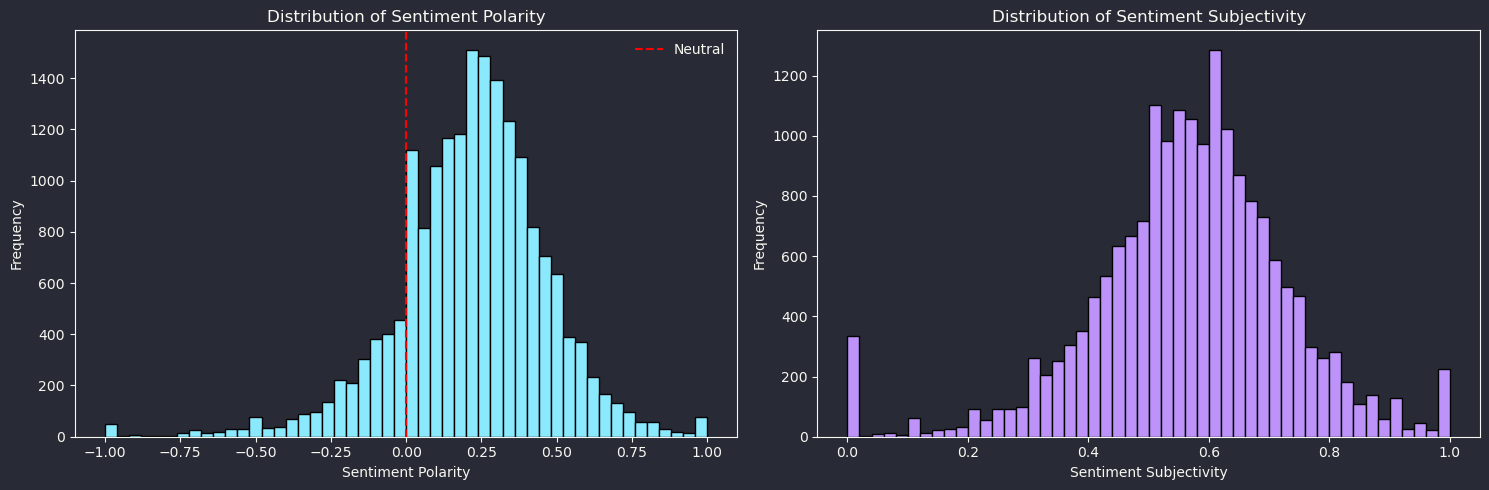

In [14]:
plt.style.use(matplotx.styles.dracula)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Polarity
axes[0].hist(df_unique['sentiment_polarity'], bins=50, color = '#8be9fd', edgecolor='black')
axes[0].axvline(x=0, color='red', linestyle='--', label='Neutral')
axes[0].set_xlabel('Sentiment Polarity')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Sentiment Polarity')
axes[0].legend()

axes[1].hist(df_unique['sentiment_subjectivity'], bins=50, color='#bd93f9', edgecolor='black')
axes[1].set_xlabel('Sentiment Subjectivity')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Sentiment Subjectivity')

plt.tight_layout()
plt.show()

The average sentiment polarity of 0.217 indicates that Sephora reviews are moderately positive overall. However, we can notice the polarity range from -1 (extremely negative) to +1(extremely positive). We can notice that 0.217 is just slight shift from the neutral to positive review. And we also can explain it by typical customer behavior, where buyers are selective about what they purchase and more likely to leave reviews for products they have opinions about (strong positive or negative). 

We can observe the normal or near-normal, slightly right-skewed distribution on both histogram plots. The broad distribution reflects that Sephora carries thousands of products with varying quality, price points, and suitability for different skin types—customers express nuanced opinions. There's no single dominant sentiment because reviews are spread across the spectrum rather than clustered at +1.0 or -1.0. Taking precisely into consideration subjectivity plot, we can see that reviews are slightly more opinion-based than fact-based. So, it means that customers use evaluative language ("amazing," "terrible," "works for me") rather than pure description (like "containing aroma, glycerin", ect.). This again supports "healthy" behavior regarding products reviews, where customers share personal experiences and judgments. 

## EDA
### Text statistics

In [15]:
# Calculate various text statistics from review text
def calculate_text_stats(text):
    if pd.isna(text) or text == "":
        return 0, 0, 0, 0, 0
    
    # Tokenize and filter to alphabetic words only
    all_tokens = word_tokenize(str(text))
    words = [w for w in all_tokens if w.isalpha()]
    sentences = sent_tokenize(str(text))
    
    return (
        len(words),
        len(text),
        len(sentences),
        np.mean([len(word) for word in words]) if words else 0,
        len(set(words))
    )

print("Calculating text statistics...")
text_stats = df_unique['full_review'].apply(calculate_text_stats)

df_unique['word_count'] = text_stats.apply(lambda x: x[0])
df_unique['char_count'] = text_stats.apply(lambda x: x[1])
df_unique['sentence_count'] = text_stats.apply(lambda x: x[2])
df_unique['avg_word_length'] = text_stats.apply(lambda x: x[3])
df_unique['unique_words'] = text_stats.apply(lambda x: x[4])

print("\nText Statistics Summary:")
print(df_unique[['word_count', 'char_count', 'sentence_count', 'avg_word_length', 'unique_words']].describe())

Calculating text statistics...

Text Statistics Summary:
         word_count    char_count  sentence_count  avg_word_length  \
count  18556.000000  18556.000000    18556.000000     18556.000000   
mean      55.108321    296.882302        4.224617         4.181720   
std       41.348956    230.427676        2.610282         0.460577   
min        1.000000     38.000000        1.000000         2.000000   
25%       30.000000    161.000000        3.000000         3.893939   
50%       45.000000    237.000000        4.000000         4.139535   
75%       65.000000    344.000000        5.000000         4.418605   
max      396.000000   2048.000000       29.000000        24.500000   

       unique_words  
count  18556.000000  
mean      42.455109  
std       25.307152  
min        1.000000  
25%       26.000000  
50%       37.000000  
75%       50.000000  
max      217.000000  


The Sephora review corpus comprises 18,556 unique reviews with a mean length of 55 words (SD = 41.3), organized into an average of 4.2 sentences. Reviews exhibit high lexical diversity (77% unique words per review), indicating authentic, user-generated content. The average word length of 4.18 characters suggests accessible, everyday language rather than technical terminology. The distribution is right-skewed, with most reviews ranging from 30-65 words, though some highly engaged customers submit detailed 300+ word assessments. We can notice that these characteristics are also consistent with mobile e-commerce review.

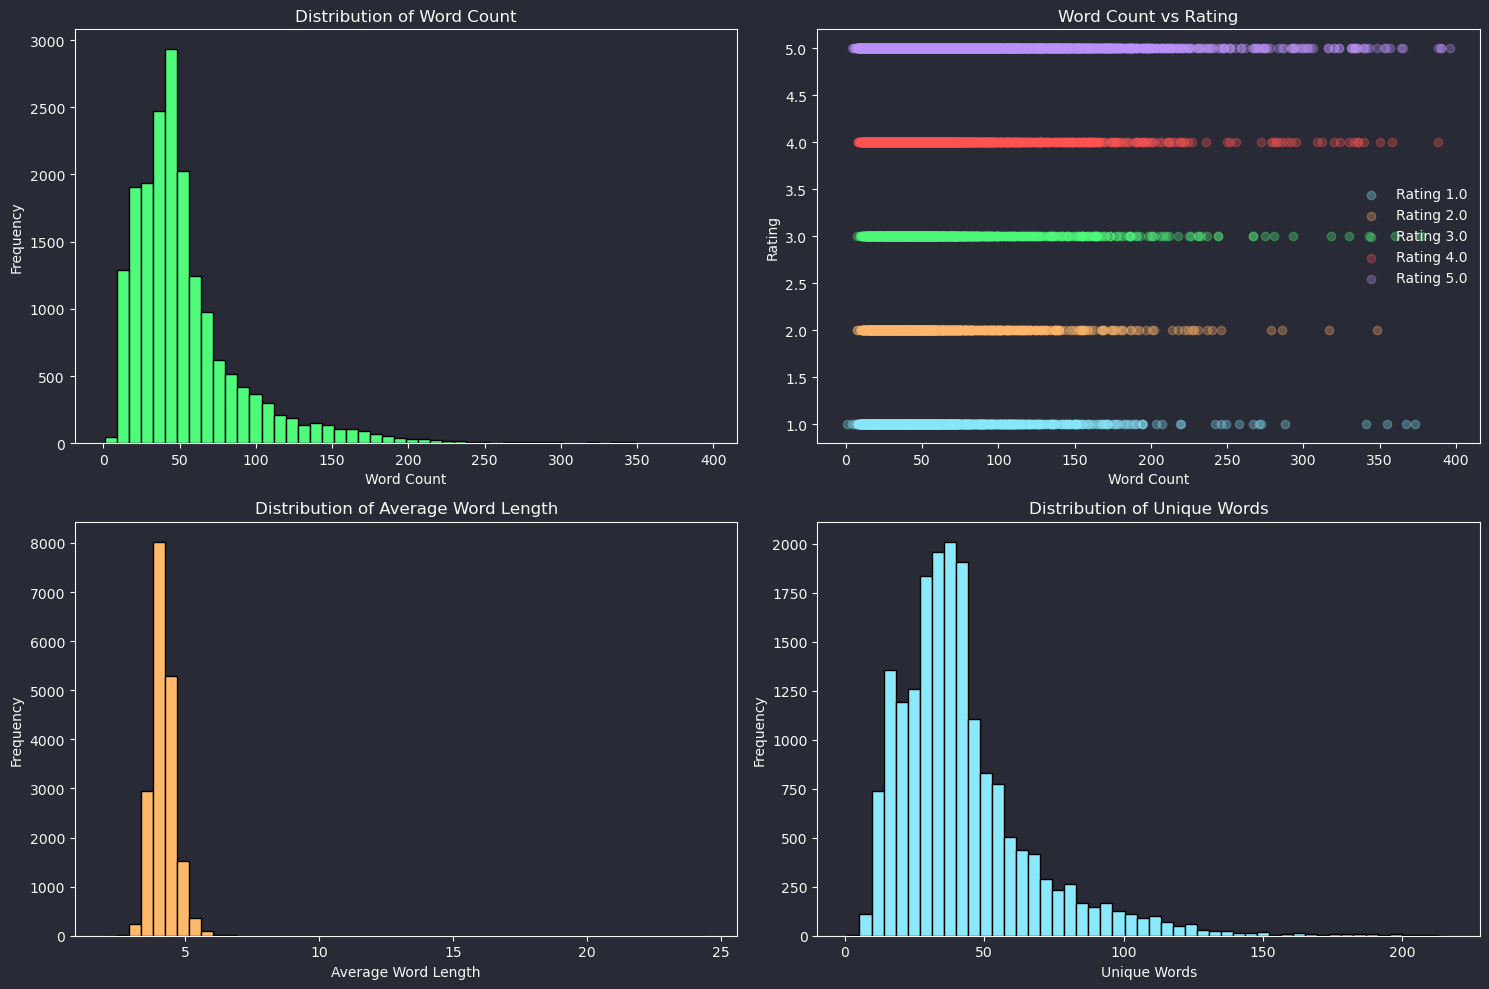

In [16]:
plt.style.use(matplotx.styles.dracula)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].hist(df_unique['word_count'], bins=50, color='#50fa7b', edgecolor='black')
axes[0, 0].set_xlabel('Word Count')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Word Count')

for rating in sorted(df_unique['rating_value'].unique()):
    subset = df_unique[df_unique['rating_value'] == rating]
    axes[0, 1].scatter(subset['word_count'], subset['rating_value'], alpha=0.3, label=f'Rating {rating}')
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].set_ylabel('Rating')
axes[0, 1].set_title('Word Count vs Rating')
axes[0, 1].legend()

axes[1, 0].hist(df_unique['avg_word_length'], bins=50, color='#ffb86c', edgecolor='black')
axes[1, 0].set_xlabel('Average Word Length')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Average Word Length')

axes[1, 1].hist(df_unique['unique_words'], bins=50, color='#8be9fd', edgecolor='black')
axes[1, 1].set_xlabel('Unique Words')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Unique Words')

plt.tight_layout()
plt.show()

The Word count distribution (top left) histogram is right‑skewed.  Most reviews fall between roughly 20 and 80 words, with a long tail up to nearly 400 words. This confirms that the typical review is concise (a short paragraph), while a minority of users write very long, detailed reviews, which pull the mean above the median. <br>

​
Word count vs rating (top right) plot shows that ratings are clearly discrete at 1–5, and for each rating there is a wide spread of word counts, mostly between about 20 and 150 words. There is no strong visual pattern that higher ratings are systematically longer or shorter. Very short and very long reviews exist at all rating levels, which suggests that review length alone is not a strong driver of rating.<br>

Average word length distribution (bottom left) displays that average word length is tightly concentrated around 4–4.5 characters, with almost all reviews in a narrow band from about 3.5 to 5. This again indicates that reviewers use simple, everyday vocabulary, which is good for readability and suggests the text is accessible and not overly technical.<br>

Unique words distribution (bottom right) per review peaks around 30–50 and is right‑skewed, extending beyond 150 unique words in a few long reviews. Compared to the total word count distribution, this implies a high proportion of unique tokens per review, so the language is not highly repetitive and the corpus offers good lexical diversity. <br>

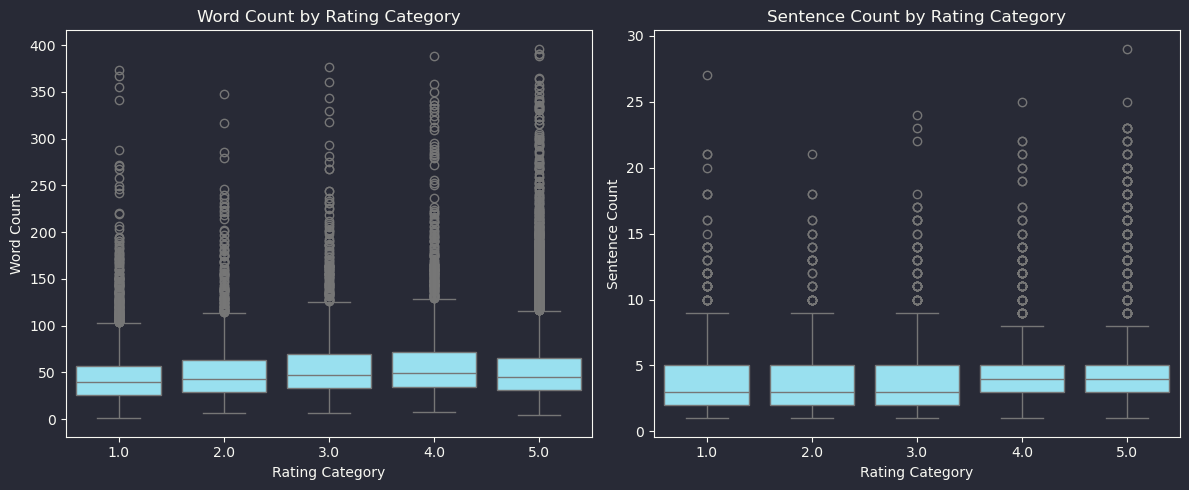

             word_count                                                      \
                  count       mean        std  min   25%   50%   75%    max   
rating_value                                                                  
1.0              2705.0  48.173013  35.732327  1.0  26.0  40.0  57.0  373.0   
2.0              1471.0  52.733515  38.229005  7.0  29.0  43.0  63.0  348.0   
3.0              1506.0  59.061753  43.427729  7.0  33.0  47.0  70.0  377.0   
4.0              2328.0  60.505584  44.988916  8.0  34.0  49.0  72.0  388.0   
5.0             10546.0  55.462450  41.708457  4.0  31.0  45.0  65.0  396.0   

             sentence_count                                                
                      count      mean       std  min  25%  50%  75%   max  
rating_value                                                               
1.0                  2705.0  3.797043  2.396340  1.0  2.0  3.0  5.0  27.0  
2.0                  1471.0  3.766825  2.348979  1.0  2.0  3.0 

In [17]:
# Length vs rating / sentiment
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=df_unique, x='rating_value', y='word_count', color='#8be9fd')
plt.title('Word Count by Rating Category')
plt.xlabel('Rating Category')
plt.ylabel('Word Count')

plt.subplot(1, 2, 2)
sns.boxplot(data=df_unique, x='rating_value', y='sentence_count', color='#8be9fd')
plt.title('Sentence Count by Rating Category')
plt.xlabel('Rating Category')
plt.ylabel('Sentence Count')

plt.tight_layout()
plt.show()

print(df_unique.groupby('rating_value')[['word_count', 'sentence_count']].describe())

The boxplots show that review length (in words and sentences) increases slightly with higher ratings, but the effect is modest and there is substantial overlap across all rating categories. Median word count rises from around 40–45 words for 1–2 star reviews to about 55–60 words for 4–5 star reviews, indicating that more satisfied customers tend to write somewhat longer reviews. However, the interquartile ranges overlap heavily, and all rating groups have many outliers extending above 150–200 words, so very long and very short reviews appear at every rating level. Median sentence count increases from roughly 2–3 sentences for low ratings to about 4–5 sentences for high ratings, again suggesting that higher ratings are associated with slightly more elaborated narratives.

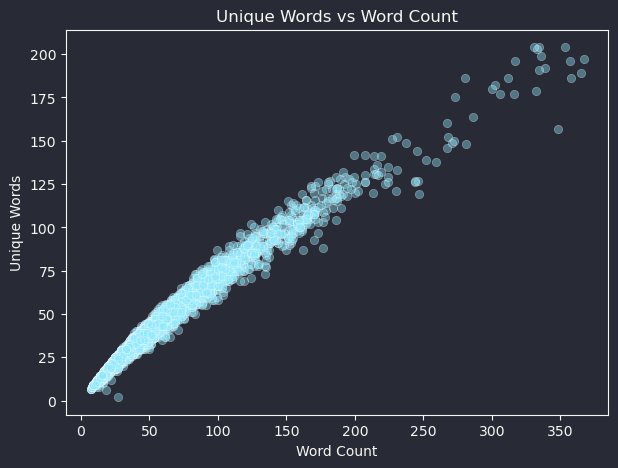


Correlation (Word_Count vs Unique_Words): 0.984


In [18]:
# Vocabulary size vs review length

plt.figure(figsize=(7, 5))
sns.scatterplot(data=df_unique.sample(min(5000, len(df_unique)), random_state=42),
                x='word_count', y='unique_words', alpha=0.4, color='#8be9fd')
plt.title('Unique Words vs Word Count')
plt.xlabel('Word Count')
plt.ylabel('Unique Words')
plt.show()

# print correlation
corr_vocab_len = df_unique['word_count'].corr(df_unique['unique_words'])
print(f"\nCorrelation (Word_Count vs Unique_Words): {corr_vocab_len:.3f}")

This plot shows a strong, almost linear relationship between review length and lexical diversity: as reviews get longer, they introduce more unique words, but with gradually decreasing marginal gains. For short reviews (up to 50 words), the number of unique words rises almost one‑to‑one with word count, implying very little repetition and highly compact messages. Beyond 100–150 words, the curve starts to flatten slightly, meaning additional length comes with more repeated words, but even at 300+ words reviews still contain well over 150 unique tokens, indicating high vocabulary richness and  authentic human writing in this corpus.

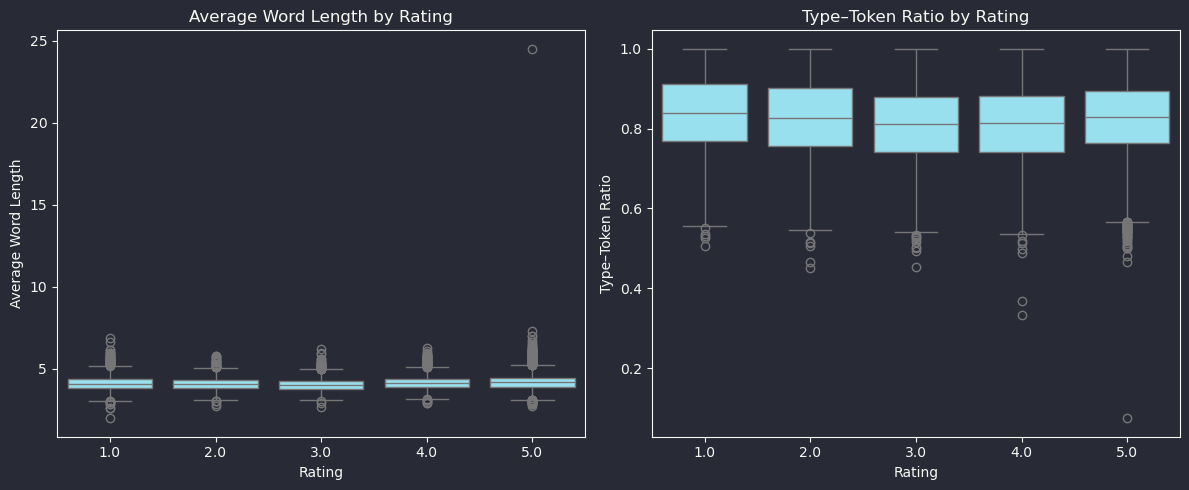


Readability/style by rating (group means):
              avg_word_length  type_token_ratio
rating_value                                   
1.0                  4.145734          0.837263
2.0                  4.098953          0.823956
3.0                  4.056437          0.807156
4.0                  4.161627          0.811335
5.0                  4.224821          0.827473


In [19]:
# Readability / style proxies

# Type–token ratio
df_unique['type_token_ratio'] = df_unique['unique_words'] / df_unique['word_count'].replace(0, np.nan)

plt.style.use(matplotx.styles.dracula)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=df_unique, x='rating_value', y='avg_word_length', color='#8be9fd')
plt.title('Average Word Length by Rating')
plt.xlabel('Rating')
plt.ylabel('Average Word Length')

plt.subplot(1, 2, 2)
sns.boxplot(data=df_unique, x='rating_value', y='type_token_ratio', color='#8be9fd')
plt.title('Type–Token Ratio by Rating')
plt.xlabel('Rating')
plt.ylabel('Type–Token Ratio')

plt.tight_layout()
plt.show()

print("\nReadability/style by rating (group means):")
print(df_unique.groupby('rating_value')[['avg_word_length', 'type_token_ratio']].mean())

These results suggest that writing style is broadly similar across ratings, with only subtle differences in complexity and lexical variety. Mean average word length ranges narrowly from about 4.06 to 4.22 characters, with 3‑star reviews using slightly shorter words and 5‑star reviews slightly longer ones. Type-token ratio (TTR) values are high overall (around 0.80–0.84), indicating rich vocabulary and low repetition in reviews at every rating level. 1‑star and 5‑star reviews show slightly higher TTR than mid‑range ratings, which suggests that very satisfied or very dissatisfied customers tend to use a bit more varied language when describing their experiences, while neutral/mixed reviews are marginally more repetitive.

Overall, EDA shows that average sentiment polarity increases sharply between 3 and 4 stars, while the difference between 1–2–3 is smaller compared to the 3–4 and 4–5 jumps. This suggests that the main semantic boundary in the data lies between 3 and 4 stars. In the light of this findings, using 4–5 as positive and 1–3 as negative categories matches the binary label, that we applied above,  with the underlying sentiment structure of the corpus.

### Other variables statistics

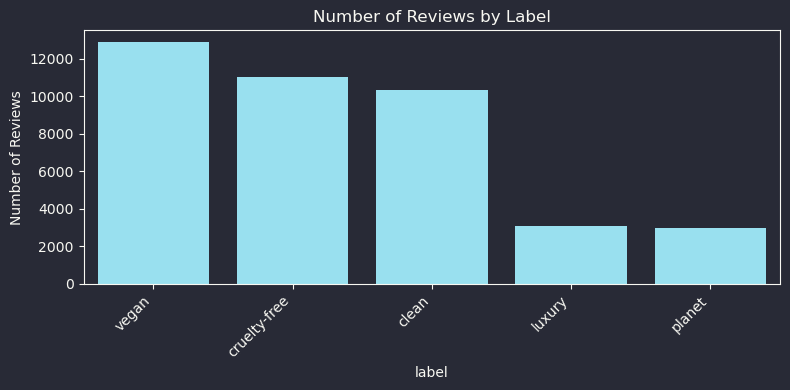

In [20]:
# Check labels 
# Basic distribution of labels
label_counts = df['label'].value_counts(normalize=False)
label_prop   = df['label'].value_counts(normalize=True)

# Average rating and price by label
label_stats = df.groupby('label').agg(
    n_reviews      = ('review_id', 'count'),
    n_products     = ('name', 'nunique'),
    avg_rating     = ('rating_value', 'mean'),
    avg_agg_rating = ('aggregate_rating', 'mean'),
    avg_price      = ('price', 'mean')
).sort_values('n_reviews', ascending=False)

plt.figure(figsize=(8, 4))
label_counts = df['label'].value_counts().sort_values(ascending=False)

sns.barplot(x=label_counts.index, y=label_counts.values, color='#8be9fd')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews by Label')
plt.tight_layout()
plt.show()

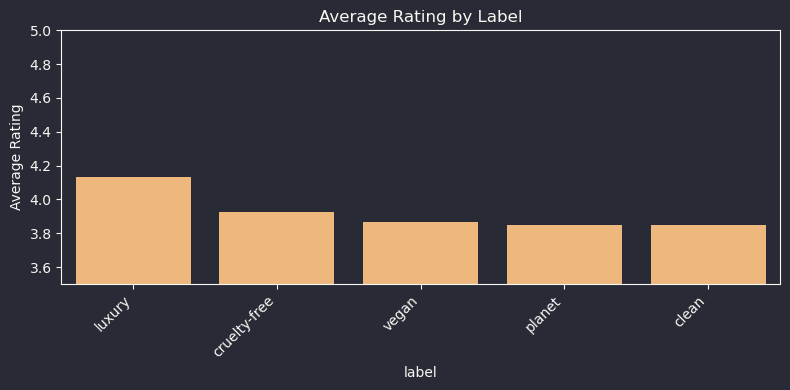

In [21]:
plt.figure(figsize=(8, 4))
label_rating = df.groupby('label')['rating_value'].mean().sort_values(ascending=False)

sns.barplot(x=label_rating.index, y=label_rating.values, color='#ffb86c')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average Rating')
plt.ylim(3.5, 5.0)
plt.title('Average Rating by Label')
plt.tight_layout()
plt.show()

Vegan, cruelty‑free, and clean products account for the large part of reviews, each with around 10k–13k observations, while luxury and planet labels are much smaller segments. This suggests that the dataset is primarily capturing mainstream “ethical/clean beauty” positioning, and inferences about luxury or planet products should be made cautiously due to lower sample size. Regarding the rating, all labels have fairly similar average ratings in the high‑3s to low‑4s range, indicating that customers are generally satisfied regardless of marketing label. Luxury products show a noticeably higher mean rating (around 4.1–4.2) than the other labels (around 3.85–3.9), which may reflect higher perceived performance, stronger brand expectations, or selection effects (fewer but more premium, well‑reviewed items).

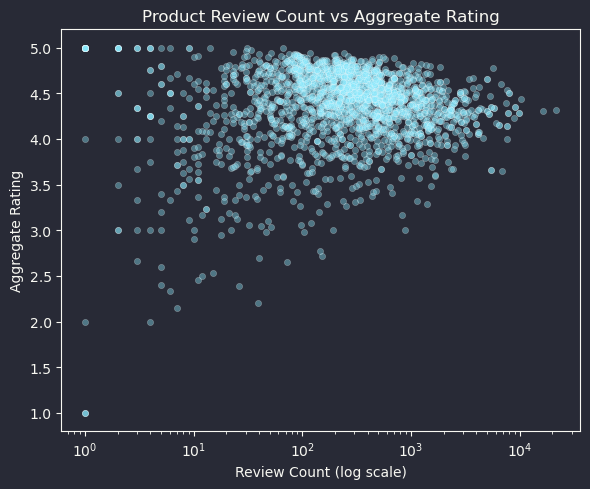

In [22]:
# Check products
product_stats = df.groupby(['name', 'brand', 'category']).agg(
    n_reviews    = ('review_id', 'nunique'),
    n_labels     = ('label', 'nunique'),
    review_count = ('review_count', 'max'),
    agg_rating   = ('aggregate_rating', 'max'),
    price        = ('price', 'max')
).reset_index()

plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=product_stats,
    x='review_count', y='agg_rating',
    alpha=0.4, s=20
)
plt.xscale('log')
plt.xlabel('Review Count (log scale)')
plt.ylabel('Aggregate Rating')
plt.title('Product Review Count vs Aggregate Rating')
plt.tight_layout()
plt.show()

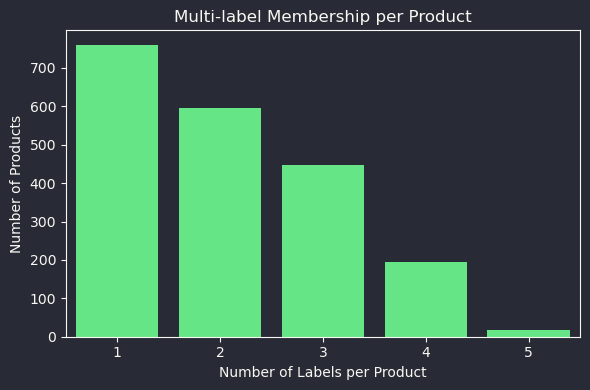

In [23]:
plt.figure(figsize=(6, 4))
sns.countplot(x='n_labels', data=product_stats, color='#50fa7b')
plt.xlabel('Number of Labels per Product')
plt.ylabel('Number of Products')
plt.title('Multi-label Membership per Product')
plt.tight_layout()
plt.show()

As we can see, most products carry only 1–3 labels, with the count dropping sharply for 4 and 5 labels. This means multi‑label marketing (like “clean” + “vegan” + “cruelty‑free”) is common but not a rule.  Only a small minority of products are tagged with the full set of five labels. Regarding the "Product Review Count vs Aggregate Rating" plot, the cloud of points sits mostly between 4.0 and 4.8 aggregate rating regardless of review count, indicating that heavily reviewed products are not systematically higher- or lower‑rated. We can notice thta even products with many reviews maintain relatively high averages.

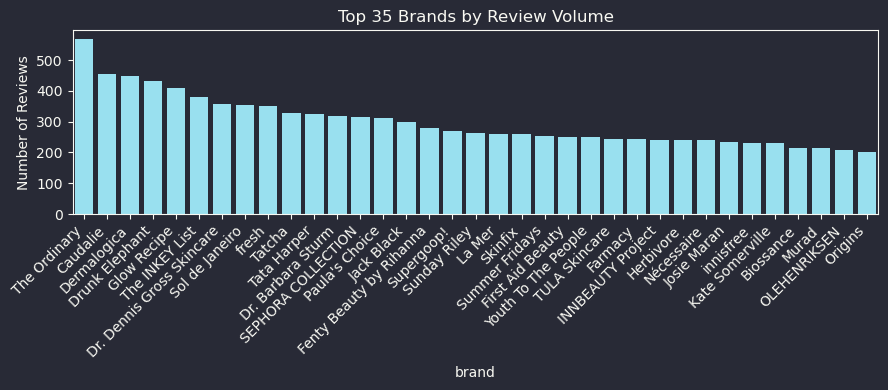

In [24]:
# Check brands 
brand_stats = df.groupby('brand').agg(
    n_reviews  = ('review_id', 'nunique'),
    n_products = ('name', 'nunique'),
    avg_price  = ('price', 'mean'),
    avg_rating = ('rating_value', 'mean')
).reset_index()

top_brands = brand_stats.sort_values('n_reviews', ascending=False).head(35)

plt.figure(figsize=(9, 4))
sns.barplot(
    data=top_brands,
    x='brand', y='n_reviews', color='#8be9fd'
)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Reviews')
plt.title('Top 35 Brands by Review Volume')
plt.tight_layout()
plt.show()

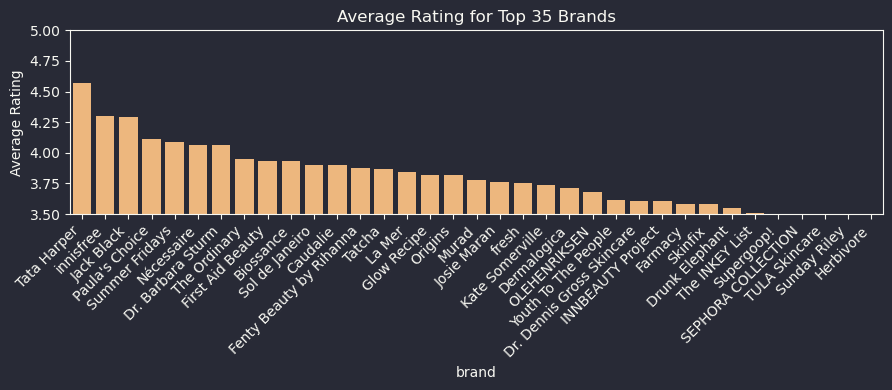

In [25]:
plt.figure(figsize=(9, 4))
sns.barplot(
    data=top_brands.sort_values('avg_rating', ascending=False),
    x='brand', y='avg_rating', color='#ffb86c'
)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average Rating')
plt.ylim(3.5, 5.0)
plt.title('Average Rating for Top 35 Brands')
plt.tight_layout()
plt.show()

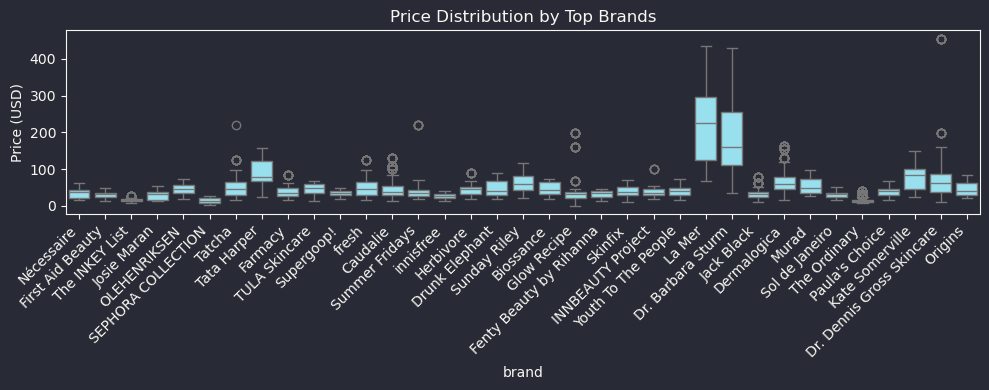

In [26]:
plt.figure(figsize=(10, 4))
sns.boxplot(
    data=df[df['brand'].isin(top_brands['brand'])],
    x='brand', y='price'
)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Price (USD)')
plt.title('Price Distribution by Top Brands')
plt.tight_layout()
plt.show()

As we can see from the review volume by brand plot, review counts are heavily skewed: a few mass brands (notably The Ordinary, Caudalie, Dermalogica, Drunk Elephant, Glow Recipe) account for far more reviews than others, indicating they dominate visibility and customer engagement on Sephora. However, we can notice that other products on average have 200-400 reviews, which is not a bad indicator. Regarding the average rating for top brands, the top 35 brands fall in a narrow band between roughly 3.6 and 4.6, so customers are generally satisfied regardless of brand. Next, taking into consideration price distributioin, the boxplot shows large price dispersion across brands: Dr. Barbara Sturm, Tata Harper and La Mer sit clearly in the luxury tier with medians well above 150–200 USD and long upper tails, while others (like The Ordinary, Paula's Choice, The INKEY List) cluster below 30 USD. Several brands have wide within-brand ranges, indicating they span entry to premium price points, whereas a few budget brands have tight, low-price boxes, reflecting consistent affordable positioning.

Overall, there is no simple monotonic relationship between price, popularity, and rating: some premium brands are well rated but niche, some affordable brands are extremely popular with solid ratings, and all brands operate in a restricted high‑rating band typical for retail platforms.

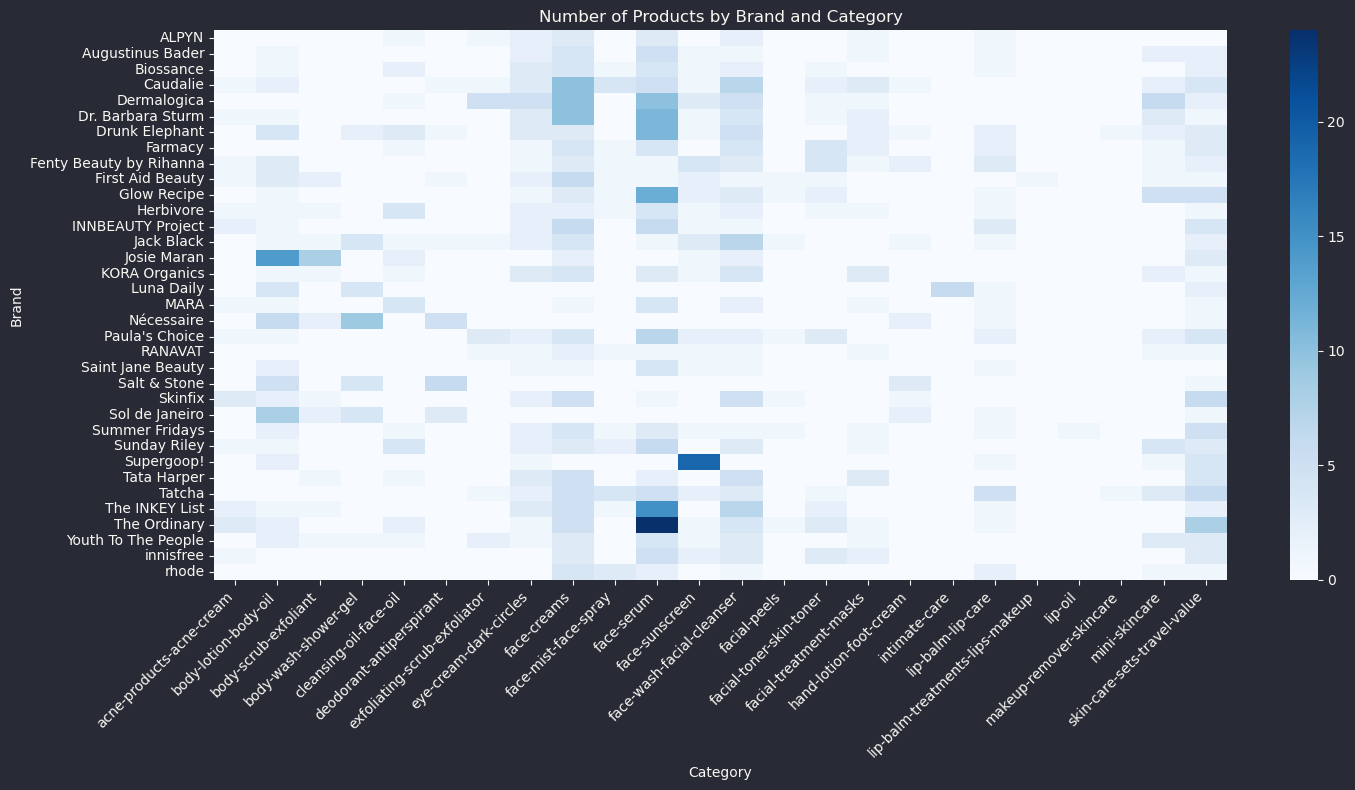

In [27]:
# Check how the brands spreaded across different product categories. Take top 20 brands and top 25 products categories. 
# Restrict to most frequent brands and categories
brand_counts = df['brand'].value_counts()
cat_counts   = df['category'].value_counts()
top_brands = brand_counts.head(35).index
top_cats   = cat_counts.head(25).index
df_bc = df[df['brand'].isin(top_brands) & df['category'].isin(top_cats)]

# Count products per (brand, category) at product level
prod_bc = (
    df_bc.groupby(['brand', 'category'])['name']
         .nunique()
         .reset_index(name='n_products')
)

# Pivot for heatmap
pivot = prod_bc.pivot(index='brand', columns='category', values='n_products').fillna(0)

plt.figure(figsize=(15, 8))
sns.heatmap(pivot, annot=False, cmap='Blues')
plt.title('Number of Products by Brand and Category')
plt.xlabel('Category')
plt.ylabel('Brand')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



The heatmap shows how each brand’s catalog is distributed across skincare categories, and it highlights which brands are specialists in a particular dimension. Darker cells indicate more products for a given (brand, category) combination, while white cells mean the brand has no products in that category. A few brands have strong vertical bands (dark cells concentrated in one or two categories), suggesting specialization. For example, some brands focus heavily on face serums, facial cleansers, or sunscreens rather than covering the whole routine. Other brands show multiple mid‑tone cells across many categories, indicating a broader, "full‑routine" positioning with cleansers, treatments, moisturizers, eye creams, and body care all represented. Several categories on the x‑axis have relatively few dark patches overall, which points to niche segments (like intimate care, deodorant, or specific exfoliants), whereas core facial skincare categories (cleansers, serums, moisturizers, masks) attract contributions from many brands.

Taking specific products per particular category into consideration, The Ordinary and The INKEY List focus heavily on face serums and targeted treatments, with darker cells in serum/actives categories and relatively lighter presence in body care or lip care. Supergoop! is concentrated in face and body sunscreen categories, reflecting its clear UV‑protection positioning rather than a full skincare line. Sol de Janeiro shows density in body lotion, scrubs, and body‑wash categories, confirming its emphasis on body care rather than facial skincare. Tata Harper, Dr. Barbara Sturm, and similar luxury brands appear mainly in high‑end facial care (serums, creams, treatment masks), with few products in mass categories like basic cleansers or body wash. 

Caudalie, Fresh, Glow Recipe, and First Aid Beauty have mid‑tone cells across several facial categories (cleansers, toners, serums, moisturizers, masks), indicating full‑routine offerings rather than narrow specialization. Paula’s Choice shows presence across exfoliants, serums, and moisturizers, with particular strength in exfoliating and treatment categories, matching its reputation for actives‑driven skincare.

KORA Organics, Summer Fridays, Herbivore appear with a handful of products in specific categories like facial oils, masks, or eye creams, suggesting small but focused assortments. Categories such as intimate care, hand/foot creams, and lip treatments have only scattered darker cells, indicating that only a few brands actively compete in these spaces.

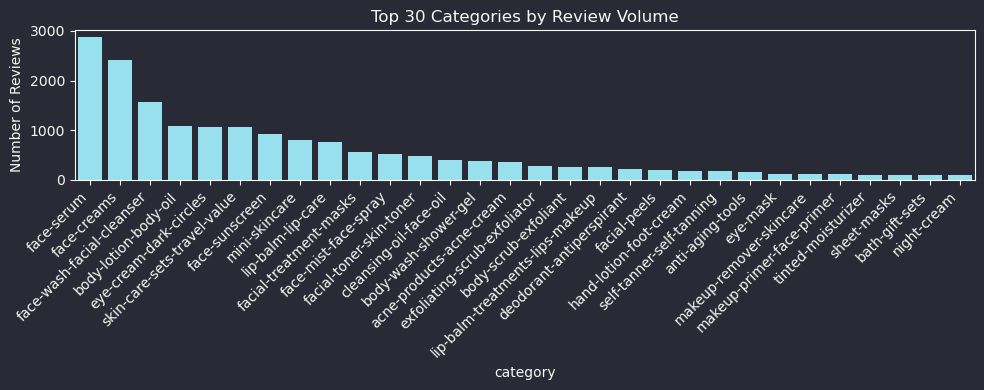

In [28]:
# Check categories more precisely 
cat_stats = df.groupby('category').agg(
    n_reviews  = ('review_id', 'nunique'),
    n_products = ('name', 'nunique'),
    avg_price  = ('price', 'mean'),
    avg_rating = ('rating_value', 'mean')
).reset_index()

cats_30 = cat_stats.sort_values('n_reviews', ascending=False).head(30)

plt.figure(figsize=(10, 4))
sns.barplot(
    data=cats_30,
    x='category', y='n_reviews', color='#8be9fd'
)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Reviews')
plt.title('Top 30 Categories by Review Volume')
plt.tight_layout()
plt.show()

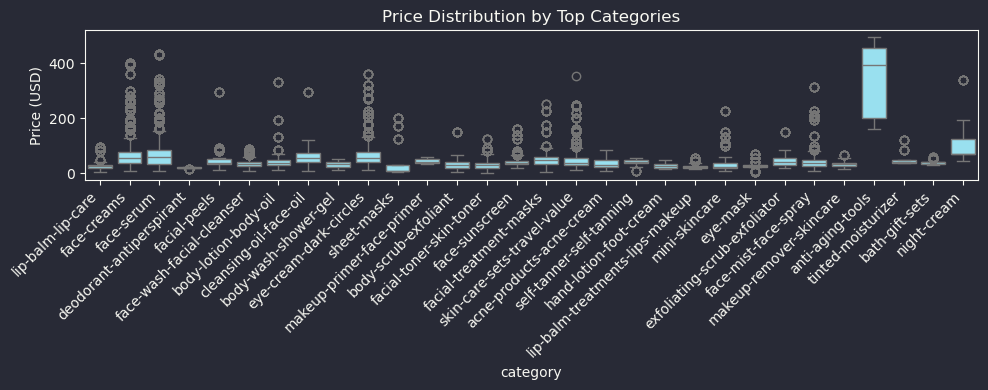

In [29]:
plt.figure(figsize=(10, 4))
sns.boxplot(
    data=df[df['category'].isin(cats_30['category'])],
    x='category', y='price'
)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Price (USD)')
plt.title('Price Distribution by Top Categories')
plt.tight_layout()
plt.show()

Across categories, prices and review volumes are highly uneven: a few core facial‑care segments dominate both assortment and customer attention, while some categories command much higher price points than others. The price boxplot shows that typical prices vary strongly by category. Face serums, facial treatment masks, and anti‑aging creams tend to sit at the higher end of the price spectrum, with many products above 100 USD and some extreme luxury outliers above 300–400 USD. Everyday items like face cleansers, body wash, deodorant, and lip balm cluster at much lower medians, often under 40–50 USD, reflecting their commodity status and larger packaging sizes. Several categories show wide boxes and long whiskers, which indicates substantial internal segmentation—from entry‑level options to very premium ones within the same functional type. For example: treatment sets, bath sets, night creams.

The review bar chart reveals that face serums and face creams are by far the most reviewed categories, followed by facial cleansers, body lotion, eye creams, and sunscreen. This pattern matches typical skincare routines: products applied directly to the face and used daily (serums, moisturizers, cleansers) generate the most customer engagement and feedback, while niche items receive far fewer reviews.

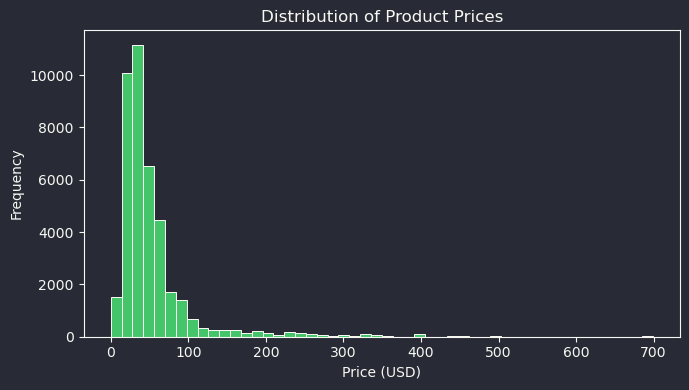

In [30]:
# Price and rating 
plt.figure(figsize=(7, 4))
sns.histplot(df['price'], bins=50, color='#50fa7b')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.title('Distribution of Product Prices')
plt.tight_layout()
plt.show()

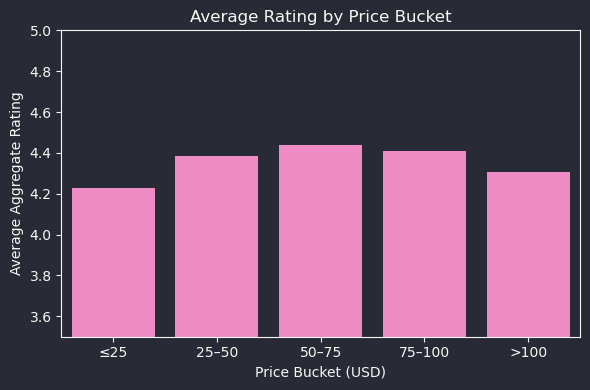

In [31]:
# Price buckets at product level
bins = [0, 25, 50, 75, 100, df['price'].max()]
labels = ['≤25', '25–50', '50–75', '75–100', '>100']
product_stats['price_bucket'] = pd.cut(product_stats['price'], bins=bins, labels=labels)
price_bucket_stats = product_stats.groupby('price_bucket')['agg_rating'].mean().reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(data=price_bucket_stats, x='price_bucket', y='agg_rating', color='#ff79c6')
plt.ylabel('Average Aggregate Rating')
plt.xlabel('Price Bucket (USD)')
plt.ylim(3.5, 5.0)
plt.title('Average Rating by Price Bucket')
plt.tight_layout()
plt.show()

From the distribution of product prices histogram we can see that data is strongly right‑skewed: most products are priced between roughly 20 and 80 USD, with a sharp peak in this range and a long tail extending towards very high prices (above 300–400 USD and up to around 700 USD). This indicates that the Sephora skincare assortment is dominated by mid‑priced products, while ultra‑premium items exist but are relatively rare. These outliers represent luxury or treatment products rather than the big part of the catalog. Regarding the average rating per price range, the average aggregate rating stays between about 4.2 and 4.45 across all buckets. Ratings rise slightly from the lowest bucket to the 50–75 USD range and then level off or dip marginally, suggesting that paying more does not guarantee dramatically higher satisfaction, but very cheap products may perform a bit worse on average.

## Word cloud analysis

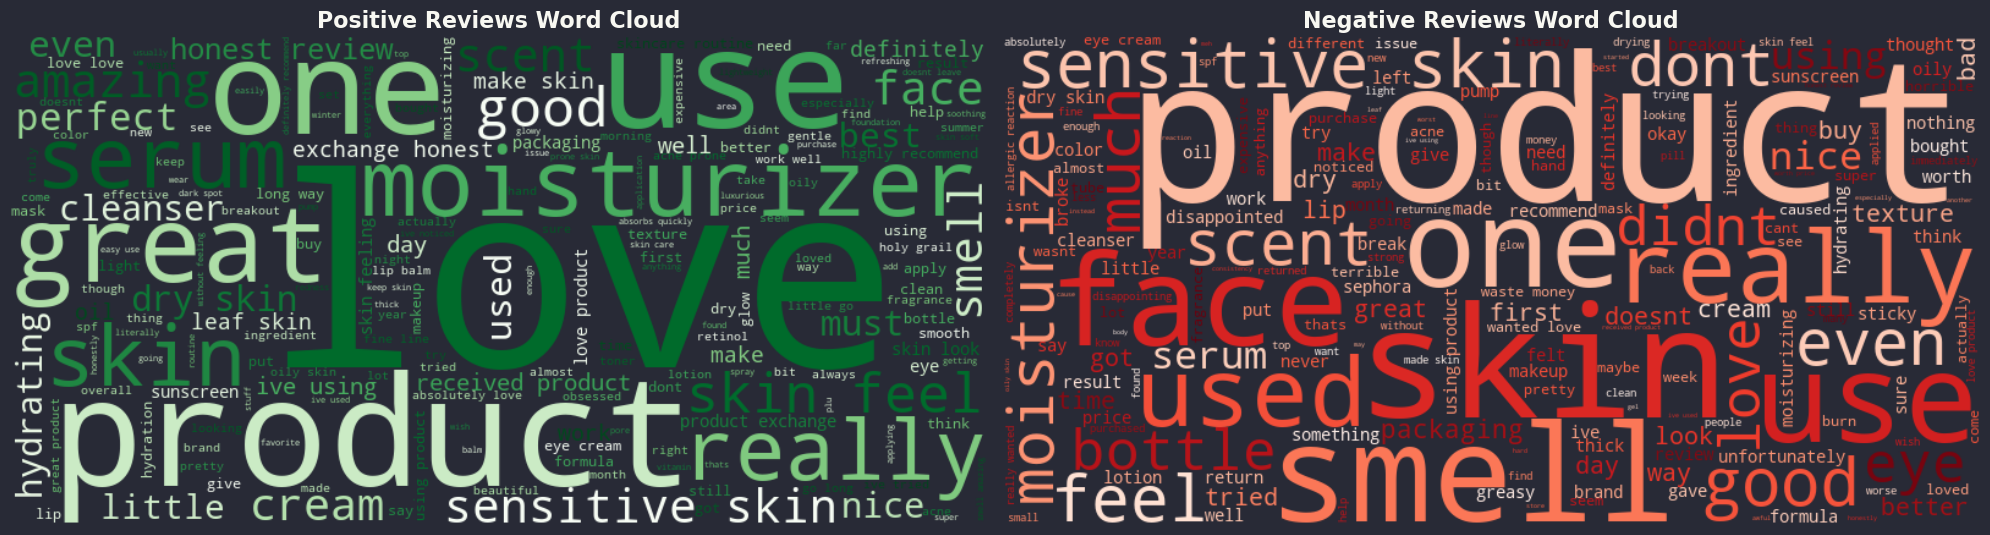

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

positive_text = ' '.join(df_unique[df_unique['rating_binary'] == 1]['processed_review'].dropna())
wordcloud_pos = WordCloud(width=800, height=400, background_color='#282a36', 
                          colormap='Greens').generate(positive_text)
axes[0].imshow(wordcloud_pos, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Positive Reviews Word Cloud', fontsize=16, fontweight='bold')

negative_text = ' '.join(df_unique[df_unique['rating_binary'] == 0]['processed_review'].dropna())
wordcloud_neg = WordCloud(width=800, height=400, background_color='#282a36', 
                          colormap='Reds').generate(negative_text)
axes[1].imshow(wordcloud_neg, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Negative Reviews Word Cloud', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

From the word cloud plot, positive reviews side, we can see that the most prominent words are "love", "great", "amazing", "product", "moisturizer", "serum", "hydrating", and "skin", which emphasizes strong affection and perceived effectiveness. Frequent co‑occurring terms like "dry skin", "sensitive skin", "feel", "glow", "hydrating", "scent" suggest that satisfied customers focus on comfort, hydration, texture, and how the product makes their skin feel and look, especially for dry or sensitive skin types.
​

On the other side, negative review cloud part, we can notice that words "product", "skin", "smell/scent", "used", "really", "dry", "sensitive", "packaging" are dominant. Compared with positive reviews, there is more emphasis on smell, packaging, and irritation: terms like "smell", "scent", "burn", "breakout", "dry skin", "sensitive skin", "bottle" point to complaints about fragrance, adverse reactions, dryness, and practical issues with the container or dispenser.
​

Overall, both groups talk heavily about product and skin, but the emotional polarity and focus differ: positive reviews center on love, glow, hydration, and comfort, while negative reviews highlight smell, irritation, dryness, and packaging problems.

## N-grams

In [38]:
def extract_ngrams(text_series, n=2, top_n=20):
    """Extract top n-grams from text series"""
    all_ngrams = []
    for text in text_series:
        if isinstance(text, str) and text:
            tokens = word_tokenize(text.lower())
            ngrams_list = list(ngrams(tokens, n))
            all_ngrams.extend(ngrams_list)
    
    ngram_freq = Counter(all_ngrams)
    return ngram_freq.most_common(top_n)

bigrams_positive = extract_ngrams(df_unique[df_unique['rating_binary'] == 1]['processed_review'], n=2, top_n=20)
bigrams_negative = extract_ngrams(df_unique[df_unique['rating_binary'] == 0]['processed_review'], n=2, top_n=20)

bigrams_positive_cl = extract_ngrams(df_unique[df_unique['rating_binary'] == 1]['cleaned_review'], n=2, top_n=20)
bigrams_negative_cl = extract_ngrams(df_unique[df_unique['rating_binary'] == 0]['cleaned_review'], n=2, top_n=20)

trigrams_positive = extract_ngrams(df_unique[df_unique['rating_binary'] == 1]['processed_review'], n=3, top_n=20)
trigrams_negative = extract_ngrams(df_unique[df_unique['rating_binary'] == 0]['processed_review'], n=3, top_n=20)

fivegrams_positive = extract_ngrams(df_unique[df_unique['rating_binary'] == 1]['processed_review'], n=5, top_n=20)
fivegrams_negative = extract_ngrams(df_unique[df_unique['rating_binary'] == 0]['processed_review'], n=5, top_n=20)

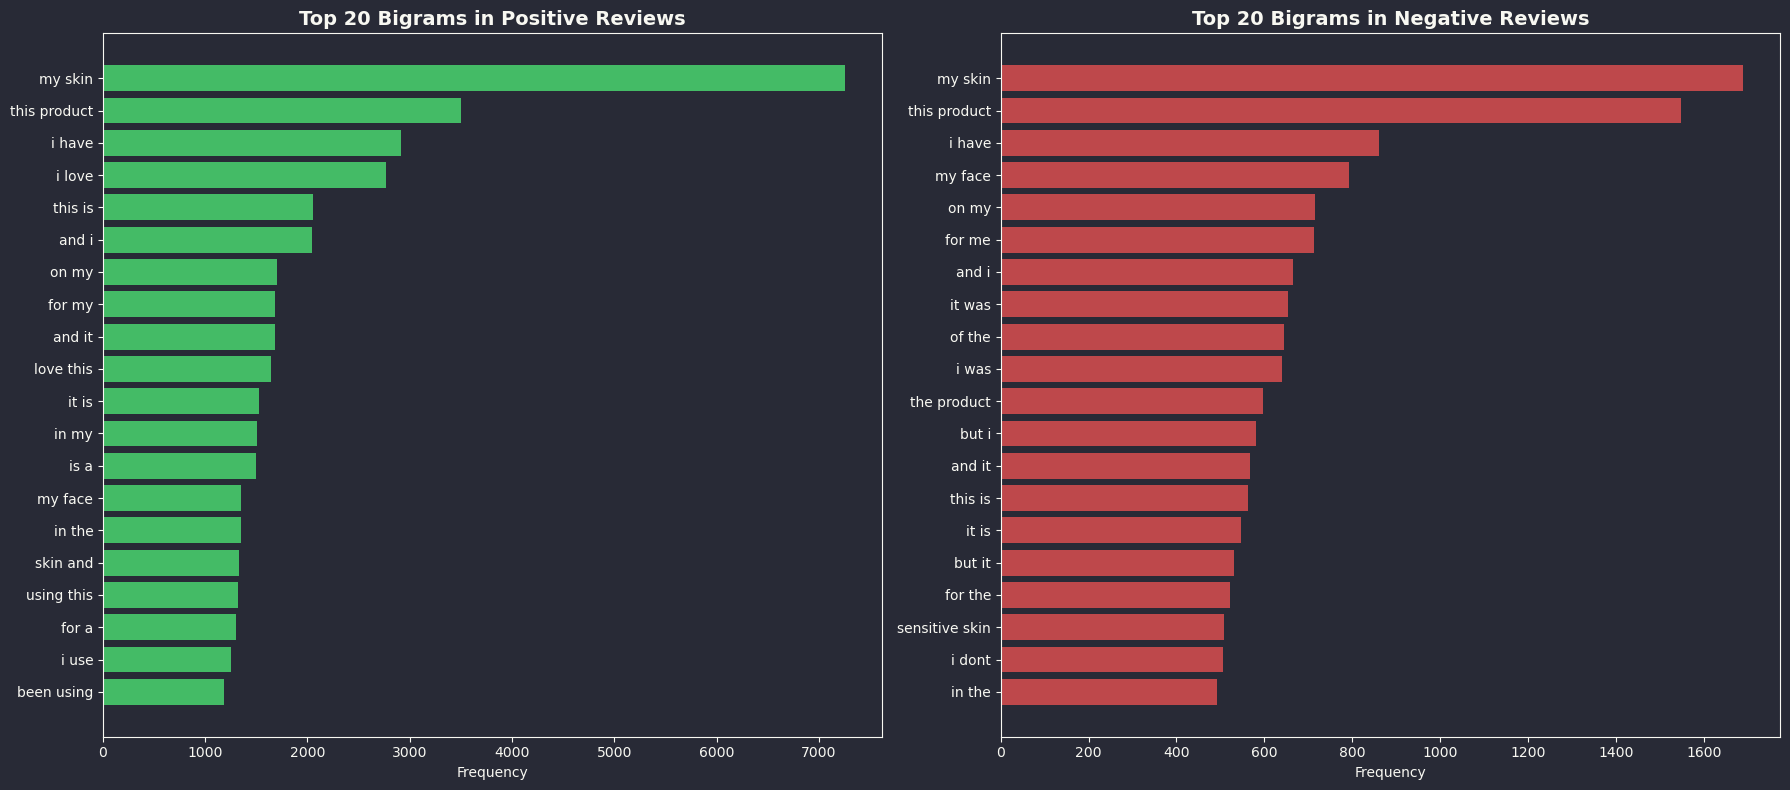

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

bigrams_pos_text = [' '.join(ng) for ng, _ in bigrams_positive_cl]
bigrams_pos_freq = [freq for _, freq in bigrams_positive_cl]
axes[0].barh(bigrams_pos_text[::-1], bigrams_pos_freq[::-1], color='#50fa7b', alpha=0.7)
axes[0].set_xlabel('Frequency')
axes[0].set_title('Top 20 Bigrams in Positive Reviews', fontsize=14, fontweight='bold')

bigrams_neg_text = [' '.join(ng) for ng, _ in bigrams_negative_cl]
bigrams_neg_freq = [freq for _, freq in bigrams_negative_cl]
axes[1].barh(bigrams_neg_text[::-1], bigrams_neg_freq[::-1], color='#ff5555', alpha=0.7)
axes[1].set_xlabel('Frequency')
axes[1].set_title('Top 20 Bigrams in Negative Reviews', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

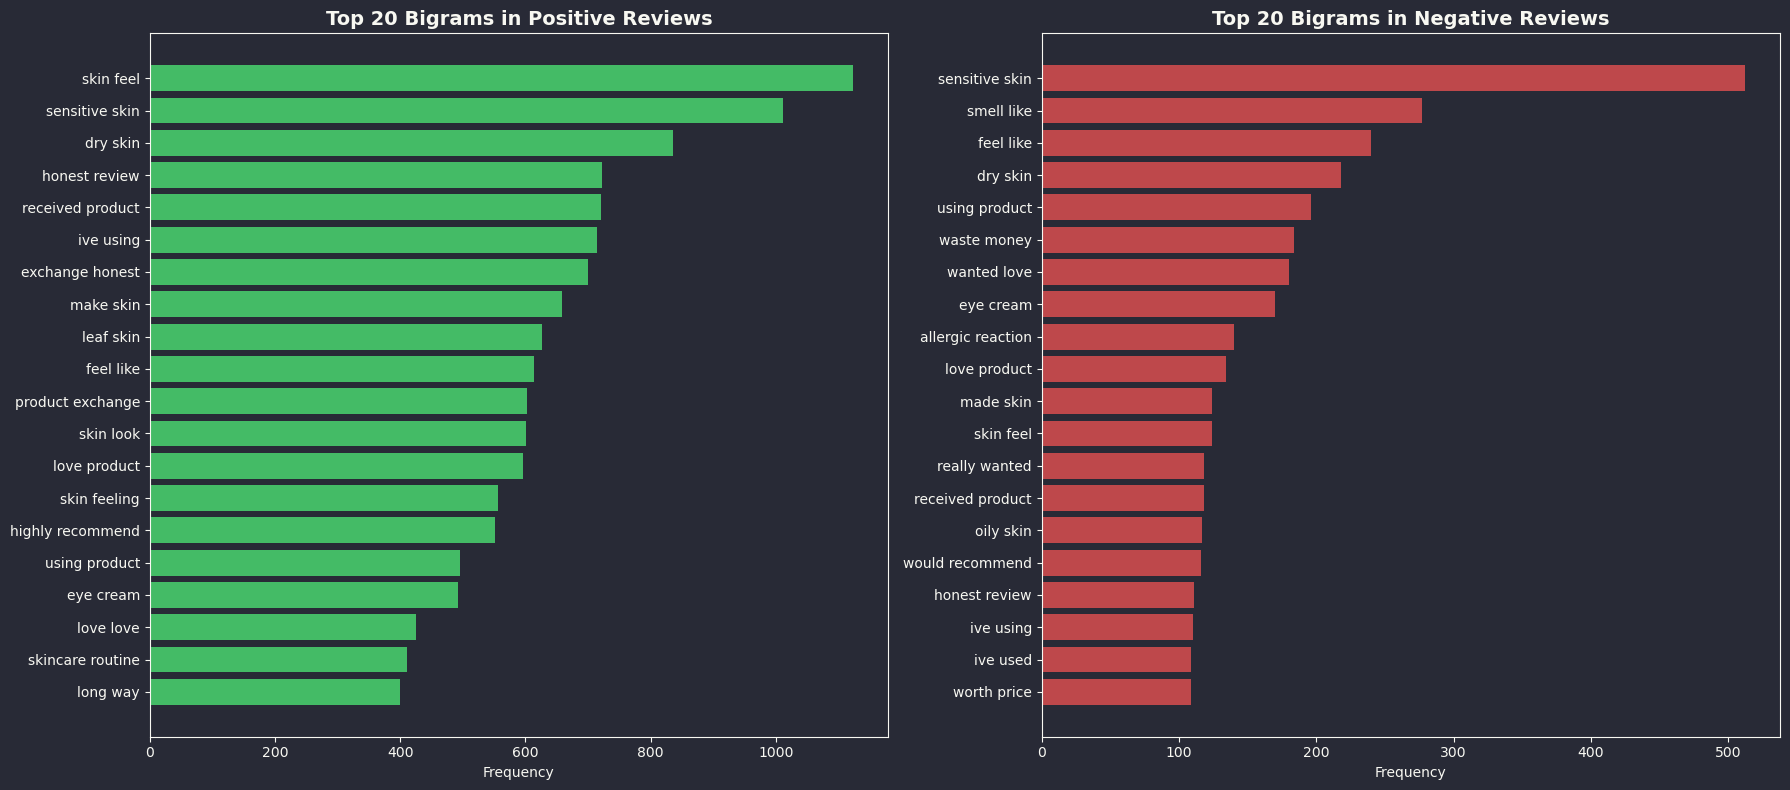

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

bigrams_pos_text = [' '.join(ng) for ng, _ in bigrams_positive]
bigrams_pos_freq = [freq for _, freq in bigrams_positive]
axes[0].barh(bigrams_pos_text[::-1], bigrams_pos_freq[::-1], color='#50fa7b', alpha=0.7)
axes[0].set_xlabel('Frequency')
axes[0].set_title('Top 20 Bigrams in Positive Reviews', fontsize=14, fontweight='bold')

bigrams_neg_text = [' '.join(ng) for ng, _ in bigrams_negative]
bigrams_neg_freq = [freq for _, freq in bigrams_negative]
axes[1].barh(bigrams_neg_text[::-1], bigrams_neg_freq[::-1], color='#ff5555', alpha=0.7)
axes[1].set_xlabel('Frequency')
axes[1].set_title('Top 20 Bigrams in Negative Reviews', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

First, we computed bigrams on lightly cleaned text, which showed that both positive and negative reviews are written from a strongly personal perspective (bigrams like "my skin", "this product", "i have"), but many of the top bigrams consisted mostly of function words and carried limited semantic content.
​

Then, using the processed_review datafame, lemmatized text with stopwords removed, we obtained more meaningful bigrams that highlight product attributes and outcomes, such as "skin feel", "dry skin", "sensitive skin", "smell like", "waste money", and "allergic reaction".
​

Comparing positive vs negative bigrams on the processed text reveals that hydration, pleasant feel, and suitability for sensitive/dry skin are key drivers of satisfaction, whereas scent, irritation on sensitive or oily skin, and perceived value for money are central themes in negative reviews.

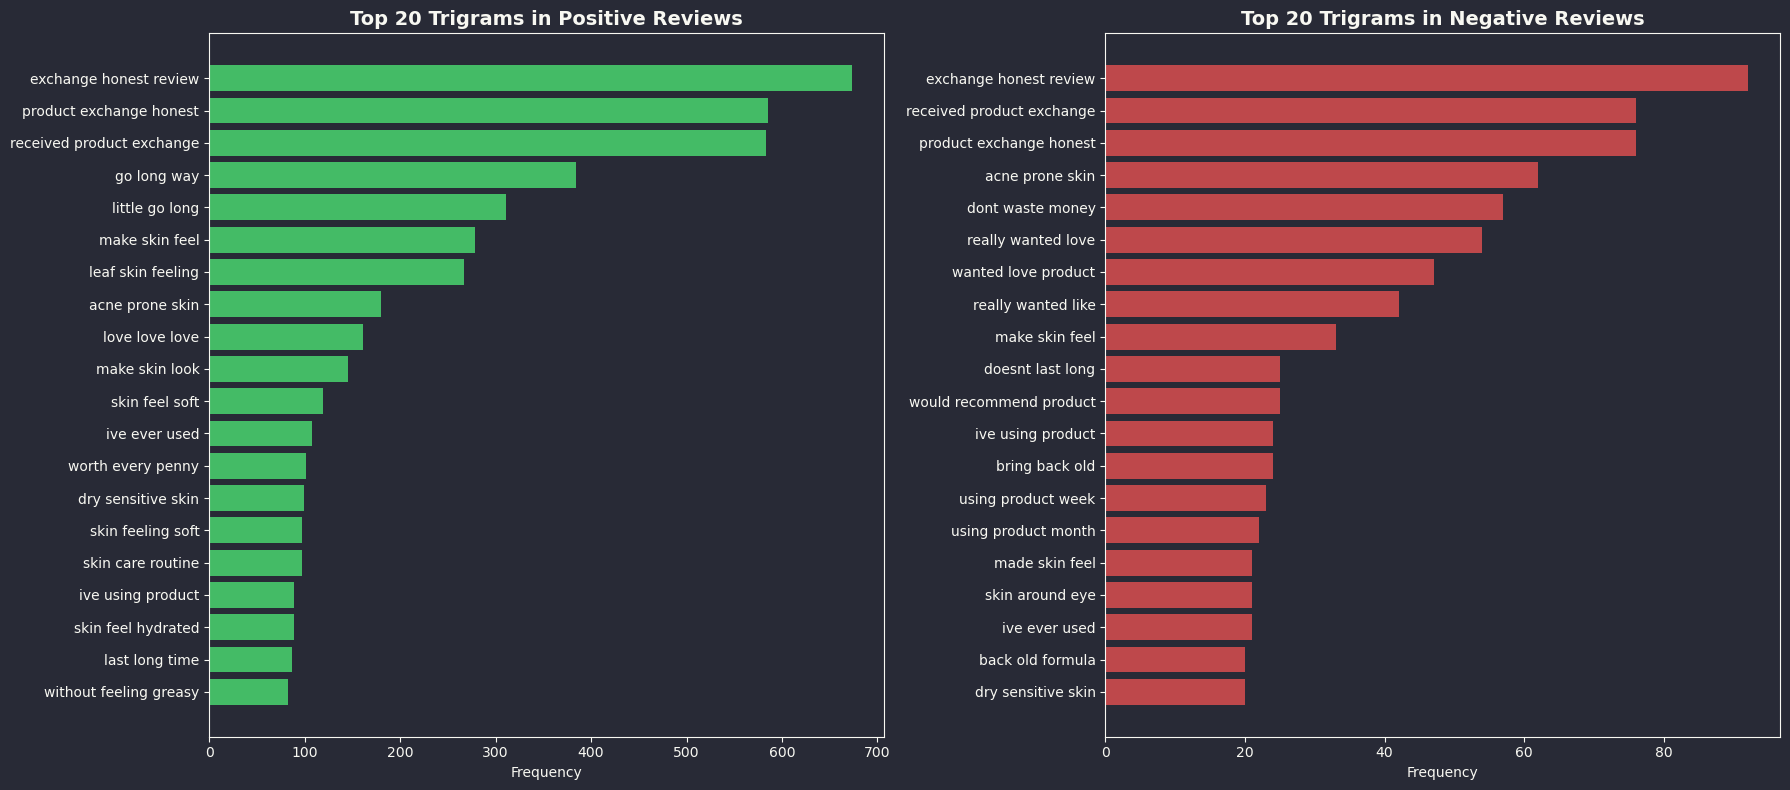

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

trigrams_pos_text = [' '.join(ng) for ng, _ in trigrams_positive]
trigrams_pos_freq = [freq for _, freq in trigrams_positive]
axes[0].barh(trigrams_pos_text[::-1], trigrams_pos_freq[::-1], color='#50fa7b', alpha=0.7)
axes[0].set_xlabel('Frequency')
axes[0].set_title('Top 20 Trigrams in Positive Reviews', fontsize=14, fontweight='bold')

trigrams_neg_text = [' '.join(ng) for ng, _ in trigrams_negative]
trigrams_neg_freq = [freq for _, freq in trigrams_negative]
axes[1].barh(trigrams_neg_text[::-1], trigrams_neg_freq[::-1], color='#ff5555', alpha=0.7)
axes[1].set_xlabel('Frequency')
axes[1].set_title('Top 20 Trigrams in Negative Reviews', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

Trigram analysis on processed reviews shows that positive reviews frequently mention long‑lasting products ("go long way", "last long time"), pleasant non‑greasy skin feel ("skin feel soft", "without feeling greasy"), and good performance on dry or sensitive skin ("dry sensitive skin"), alongside explicit value statements ("worth every penny"). In contrast, negative reviews revolve around disappointment and value concerns ("dont waste money", "really wanted love [the product]", "doesnt last long", "make skin feel"), lack of results over weeks or months, and issues for sensitive skin or after formula changes ("back old formula").

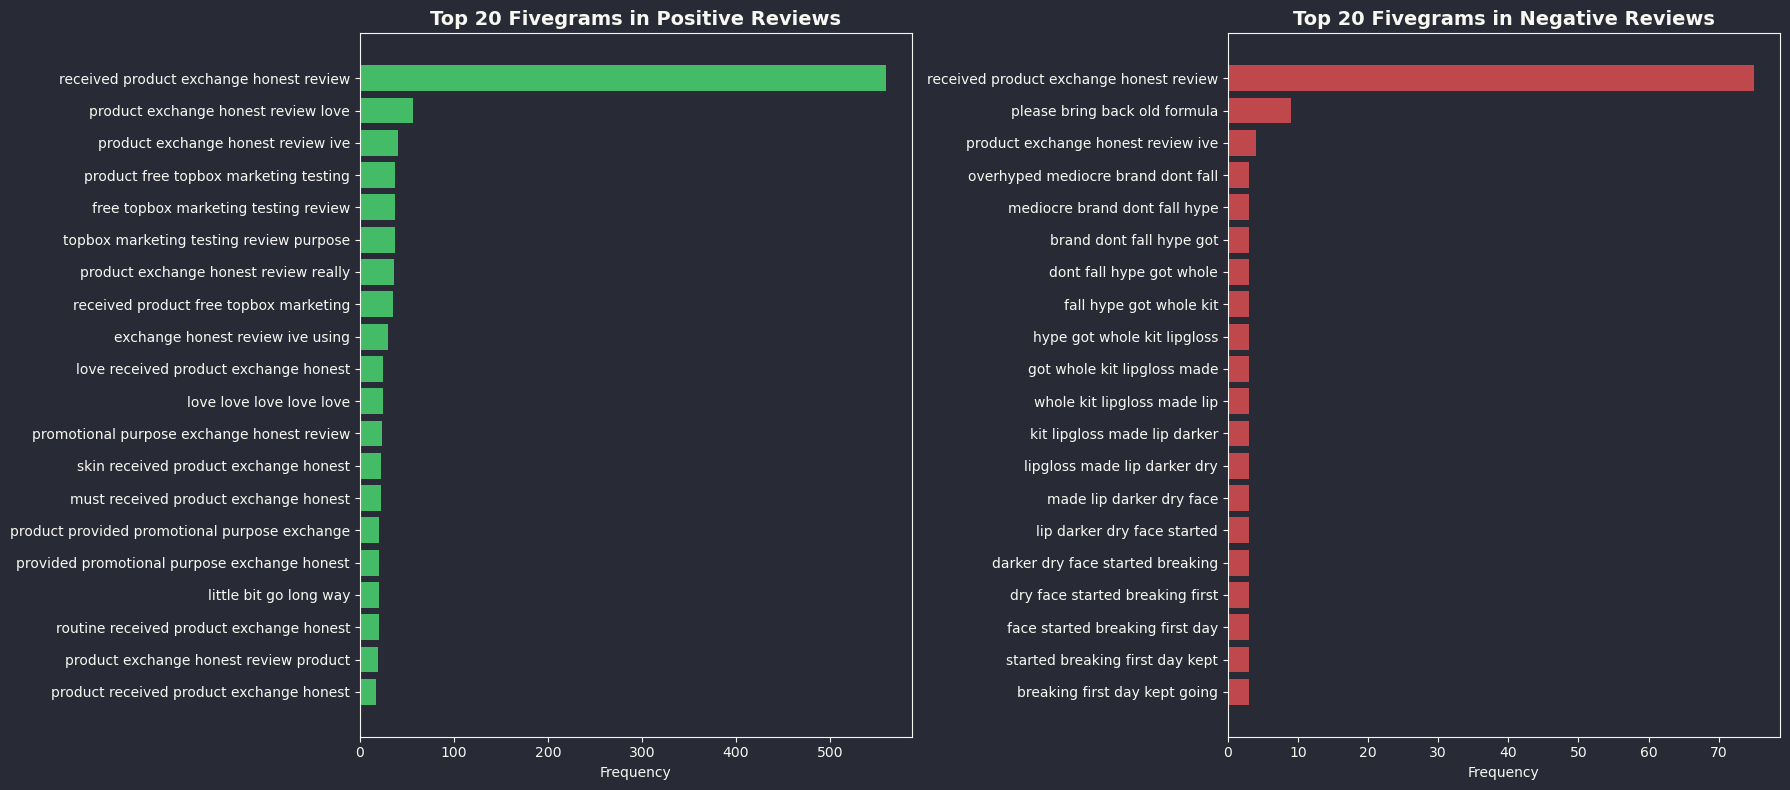

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

fivegrams_pos_text = [' '.join(ng) for ng, _ in fivegrams_positive]
fivegrams_pos_freq = [freq for _, freq in fivegrams_positive]
axes[0].barh(fivegrams_pos_text[::-1], fivegrams_pos_freq[::-1], color='#50fa7b', alpha=0.7)
axes[0].set_xlabel('Frequency')
axes[0].set_title('Top 20 Fivegrams in Positive Reviews', fontsize=14, fontweight='bold')

fivegrams_neg_text = [' '.join(ng) for ng, _ in fivegrams_negative]
fivegrams_neg_freq = [freq for _, freq in fivegrams_negative]
axes[1].barh(fivegrams_neg_text[::-1], fivegrams_neg_freq[::-1], color='#ff5555', alpha=0.7)
axes[1].set_xlabel('Frequency')
axes[1].set_title('Top 20 Fivegrams in Negative Reviews', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

As we can notice, almost all top 5‑grams are variants of "received product exchange honest review", "product exchange honest review love", and phrases mentioning "free topbox marketing testing promotional purpose", which are standard disclosure sentences. This tells us that a substantial fraction of positive reviews come from incentivized or sample‑based programs, but beyond that, 5‑grams add little new information beyond what our trigrams already captured (like "go long way", "worth every penny").

The leading negative 5‑gram is again the disclosure sentence ("received product exchange honest review"), showing that some negative reviews are also incentivized. The next set of 5‑grams forms a coherent narrative about disappointment with a reformulated lip product: "please bring back old formula", "overhyped mediocre brand dont fall", "dont fall hype got whole kit", and a series of phrases about a lipgloss kit making lips darker and dry, skin breaking out from day one. These describe one or a few very specific product issues rather than broad patterns across the dataset.

This justifies focusing our substantive interpretation on bigrams and trigrams, where we captured clearer, recurring themes about hydration, sensitive skin, scent, irritation, and value for money across many products.

## Text clustering

In [48]:
df_cluster = df_unique.copy()
texts = df_cluster['processed_review'].tolist()

In [49]:
tfidf = TfidfVectorizer(
    max_df=0.5,           # ignore extremely common terms
    min_df=10,            # ignore very rare terms
    ngram_range=(1, 2),   # unigrams + bigrams
    max_features=20000    # cap dimensionality
)

X_tfidf = tfidf.fit_transform(texts)
feature_names = np.array(tfidf.get_feature_names_out())
print(f"TF-IDF matrix shape: {X_tfidf.shape}")

TF-IDF matrix shape: (18556, 8996)


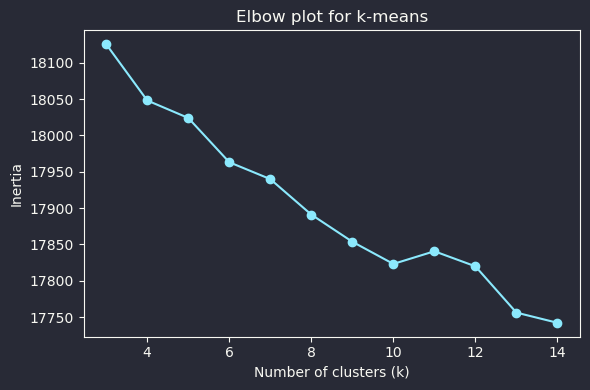

In [53]:
inertias = []
K_range = range(3, 15)

for k in K_range:
    km = MiniBatchKMeans(
        n_clusters=k,
        random_state=42,
        batch_size=2048,
        n_init=10
    )
    km.fit(X_tfidf)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(list(K_range), inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow plot for k-means")
plt.tight_layout()
plt.show()

In [55]:
k = 6  # set based on elbow plot
kmeans = MiniBatchKMeans(
    n_clusters=k,
    random_state=42,
    batch_size=2048,
    n_init=20
)
clusters = kmeans.fit_predict(X_tfidf)

df_cluster['cluster'] = clusters

In [56]:
def top_terms_per_cluster(model, feature_names, n_top=15):
    order_centroids = model.cluster_centers_.argsort(axis=1)[:, ::-1]
    cluster_terms = {}
    for i in range(model.n_clusters):
        terms = feature_names[order_centroids[i, :n_top]]
        cluster_terms[i] = terms
    return cluster_terms

cluster_keywords = top_terms_per_cluster(kmeans, feature_names, n_top=15)

for c, terms in cluster_keywords.items():
    print(f"\nCluster {c}:")
    print(", ".join(terms))



Cluster 0:
product, using, acne, used, use, face, ive, work, price, didnt, one, worth, get, time, dont

Cluster 1:
smell, lip, like, product, feel, good, use, really, love, smell like, balm, nice, dont, scent, using

Cluster 2:
sensitive, sensitive skin, cleanser, feeling, makeup, feel, great, face, leaf, dry, use, moisturizer, doesnt, soft, sunscreen

Cluster 3:
honest, exchange, received product, honest review, exchange honest, received, product exchange, review, product, feel, great, scent, nice, love, packaging

Cluster 4:
love, product, serum, feel, love product, routine, great, love love, must, use, scent, glow, make, amazing, way

Cluster 5:
eye, eye cream, cream, product, dark, work, circle, use, area, dark circle, using, love, around, around eye, really


Now we can observe clusters in more details. Lets start with the first one. 

**Cluster 0 – Effectiveness, acne, and value for money**, Top terms like "product, using, acne, used, use, face, ive, work" suggest reviews focused on whether the product works on the face, especially for acne‑related concerns. The presence of "price, didnt, worth, get, time, dont" indicates many reviewers explicitly discuss value for money and disappointment when the product did not work over time, so this cluster is likely mixed or skewed negative on effectiveness + cost.

**Cluster 1 – Lip products and scent**. Keywords "smell, lip, like, balm, scent" clearly point to lip balms/glosses and fragrance. Mixed sentiment words ("good, really, love, nice" versus "dont") suggest that scent and feel on the lips are central evaluation criteria, with some users loving the fragrance/texture and others disliking it.

**Cluster 2 – Sensitive skin, cleansers, and basic skincare**. Phrases like "sensitive, sensitive skin, cleanser, makeup, face, moisturizer, sunscreen" show this cluster gathers core routine products (cleansers, moisturizers, sunscreen) aimed at sensitive or dry skin. Positive descriptors ("great, leaf, soft") plus negatives like "doesnt, dry" indicate a mix of reviews about how gentle or drying the products feel on sensitive skin.

**Cluster 3 – Incentivized reviews and packaging**. The dominant phrases "honest, exchange, received product, honest review, product exchange" are classic disclosure sentences for PR or sample products, marking this as the "incentivized review" cluster. Within those reviews, content words like "feel, great, scent, nice, love, packaging" show they often talk about pleasant feel, nice scent, and attractive packaging, so the tone is probably skewed positive but formally phrased.

**Cluster 4 – Enthusiastic praise for serums and glow**. Very positive sentiment words dominate: "love, love product, love love, great, amazing, must, glow" alongside "serum, routine, feel, scent, make, way". This looks like the "holy‑grail serum / skincare routine" cluster, where users admire about how a product fits into their routine, provides glow, and is a must‑have they genuinely love.

**Cluster 5 – Eye creams and dark circles**. Terms "eye, eye cream, cream, dark, circle, dark circle, area, around eye" clearly indicate eye‑area treatments for dark circles. Words "work, using, love, really" show that reviews often focus on whether the cream actually improves dark circles and how it feels around the eyes, with both success and failure stories.

Overall, we can see that clustering reveals distinct thematic segments, such as acne and value, lip/scent products, sensitive‑skin basics, incentivized reviews, glowing serum praise, and eye‑cream evaluations. This confirms that the TF‑IDF representation plus k‑means is capturing meaningful structure in the review corpus.

In [ ]:
cluster_summary = df_cluster.groupby('cluster').agg(
    n_reviews=('processed_review', 'count'),
    pos_share=('rating_binary', 'mean') # to check whether positive or negative reviews prevail
).reset_index()

cluster_summary['pos_share'] = cluster_summary['pos_share'].round(3)
cluster_summary

,cluster,n_reviews,pos_share
0,0,6652,0.534
1,1,3140,0.591
2,2,3722,0.842
3,3,801,0.876
4,4,3158,0.944
5,5,1083,0.599


We can observe that clusters 2–4 capture clearly positive experiences (pos_share from 0.842 to 0.944), while clusters 0–1 and 5 contain more mixed or critical evaluations (pos_share between 0.534 and 0.599).

In [60]:
pd.crosstab(df_cluster['cluster'], df_cluster['label'])

label,clean,cruelty-free,luxury,planet,vegan
cluster,,,,,
0,3336,1513,630,35,1138
1,1706,772,175,26,461
2,2009,859,313,38,503
3,343,319,102,1,36
4,1606,722,300,47,483
5,522,192,156,3,210


Additionally, we can see that highly positive clusters (2–4) are dominated by clean, cruelty‑free, and often luxury products, especially for serums and sensitive‑skin care, while more mixed clusters (0–1, 5) contain a higher fraction of mainstream clean/vegan offerings and targeted treatments where effectiveness and value are more contested.

In [59]:
pd.crosstab(df_cluster['cluster'], df_cluster['category'])

category,acne-products-acne-cream,anti-aging-tools,bath-gift-sets,bb-cc-cream-face-makeup,bb-cream-cc-cream,beauty-supplements-bath-body,blotting-paper-oil-control-skincare,blush,body-care,body-hyperpigmentation-products,body-lotion-body-oil,body-mist-hair-mist,body-scrub-exfoliant,body-stretch-mark-firming-cream,body-wash-shower-gel,bronzer-makeup,bubble-bath-oil,cleanser,cleansing-oil-face-oil,concealer,deodorant-antiperspirant,exfoliating-scrub-exfoliator,eye-cream-dark-circles,eye-mask,face-creams,face-mist-face-spray,face-serum,face-sunscreen,face-tanner-self-tanner-face,face-wash-facial-cleanser,face-wipes,facial-cleansing-brushes,facial-peels,facial-toner-skin-toner,facial-treatment-masks,foundation-makeup,hair-clips-hair-bands,hair-oil-treatment,hair-supplements,hair-towels,hand-lotion-foot-cream,hand-sanitizer-soap,holistic-wellness,intimate-care,lip-balm-lip-care,lip-balm-treatments-lips-makeup,lip-gloss,lip-oil,lip-plumper,lip-stain,lipstick,liquid-lipstick,luminizer-luminous-makeup,makeup-kits-makeup-sets,makeup-primer-face-primer,makeup-remover-skincare,makeup-removers,mascara,mini-bath-products,mini-hair-products,mini-makeup,mini-perfume,mini-skincare,mom-baby-bath-body,night-cream,perfume,perfume-gift-sets,professional-beauty-tools,scalp-massagers-rollers,self-tanner-self-tanning,setting-powder-face-powder,sheet-masks,shop-travel-size-bath-products,shop-travel-size-hair-products,shop-travel-size-makeup,skin-care-gift-sets,skin-care-sets-travel-value,skin-care-tools,sunscreen,sunscreen-bath-body,tinted-moisturizer,vitamins-for-hair-skin-nails,wellness-products
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,260,92,24,3,6,6,5,12,9,7,289,12,128,6,75,5,12,2,143,2,59,104,225,13,820,206,1292,267,34,405,3,18,110,246,251,14,9,3,63,5,37,7,10,24,100,38,8,15,9,0,2,1,3,3,50,36,9,10,7,7,27,3,237,2,32,4,2,3,5,99,13,50,5,9,6,14,346,37,20,6,52,59,0
1,24,9,20,2,2,1,0,17,0,1,347,37,53,2,121,2,10,0,71,0,87,26,42,10,201,55,221,89,10,100,4,1,17,36,46,5,0,1,1,0,62,21,5,10,573,196,35,62,9,8,15,9,8,0,11,7,2,0,17,1,11,2,58,0,6,9,1,0,0,43,5,19,4,0,12,15,178,7,10,6,13,13,6
2,24,5,15,1,1,0,1,2,0,2,208,0,41,0,95,1,2,7,67,0,24,54,28,3,718,95,366,342,3,745,6,6,35,87,144,11,0,0,1,1,28,3,2,13,6,1,1,0,0,0,0,0,3,0,19,43,6,0,9,1,20,0,134,8,27,0,0,1,1,7,4,9,3,0,6,0,189,2,8,5,22,0,0
3,12,1,1,0,0,0,0,0,0,0,36,4,2,0,4,0,0,0,25,0,17,17,52,6,122,31,174,45,0,67,0,0,0,24,13,0,0,0,1,0,0,0,0,24,29,0,0,5,0,0,0,0,1,0,5,0,0,0,0,0,0,0,26,0,9,1,0,0,0,1,0,1,6,0,0,0,39,0,0,0,0,0,0
4,50,34,35,3,1,3,4,18,1,0,206,18,42,2,67,2,6,1,79,6,30,46,57,10,433,115,679,126,13,156,2,5,26,74,92,10,1,0,4,4,24,8,3,9,47,17,6,5,2,3,3,1,5,0,23,8,0,0,8,1,16,5,112,0,15,6,1,3,4,20,8,10,2,1,6,10,258,8,8,3,13,11,4
5,0,9,0,1,0,0,0,1,0,0,2,0,1,0,1,0,0,0,3,2,0,1,670,78,45,9,63,36,0,60,5,0,2,2,4,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,21,3,0,1,0,6,0,5,0,0,0,0,0,0,0,0,0,0,0,0,1,45,0,1,0,1,0,0


From the product categories per cluster table we can also notice the same patterns. Acne-products-acne-cream is highest in cluster 0 (260 vs 24–50 in others), which matches our "acne/effectiveness/value" interpretation for cluster 0. Cluster 1 has by far the largest counts, especially lip-balm-lip-care (573) and lip-balm-treatments-lips-makeup (196), fitting the "lip + smell/feel" topic. Cluster 2 is very strong in face-wash-facial-cleanser (745), cleanser (67), face-sunscreen (342), and facial-toner-skin-toner (87), consistent with "sensitive skin / cleanser / sunscreen" reviews topic. Cluster 4 is strong in face-serum (679) and face-creams (433), and has good representation in sets/gifts, matching the "love love / serum / glow / routine" cluster. Cluster 5 is overwhelmingly dominated by eye-cream-dark-circles (670) and eye-mask (78), which fits the "eye cream / dark circles" topic.

In [61]:
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())

tsne = TSNE(
    n_components=2,
    random_state=42,
    perplexity=40,
    learning_rate='auto',
    init='pca'
)
X_tsne = tsne.fit_transform(X_pca)

df_vis = pd.DataFrame({
    'tsne1': X_tsne[:,0],
    'tsne2': X_tsne[:,1],
    'cluster': clusters
})


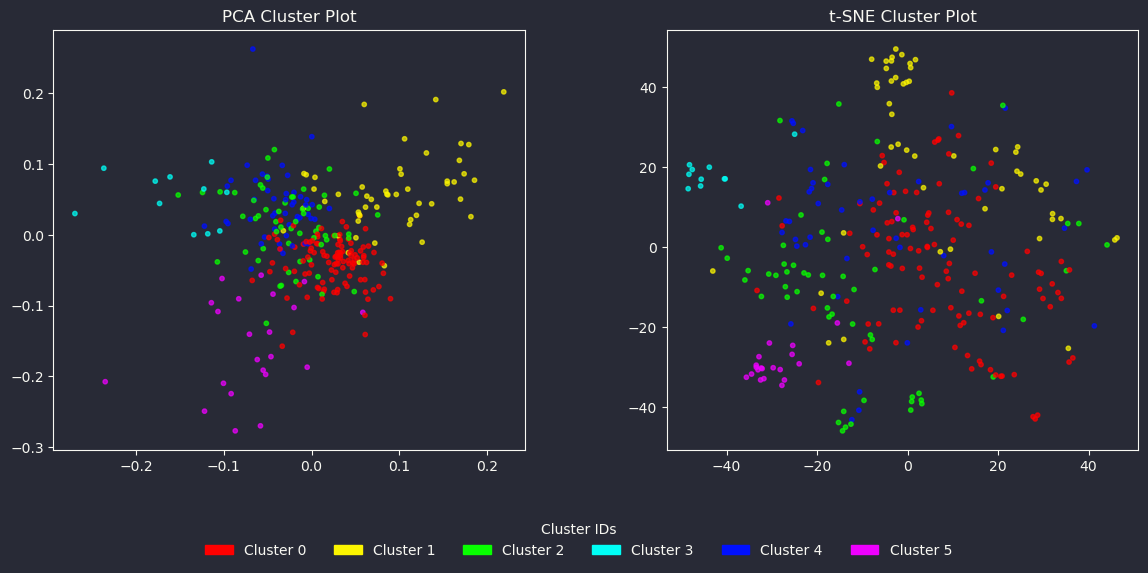

In [ ]:
def plot_tsne_pca(data, labels, seed=42):
    rng = np.random.RandomState(seed)

    # Sample up to 3000 points for visualization
    n_samples = min(3000, data.shape[0])
    idx = rng.choice(data.shape[0], size=n_samples, replace=False)

    X = data[idx].toarray() if hasattr(data, "toarray") else np.asarray(data[idx])
    # PCA (2D)
    pca = PCA(n_components=2, random_state=seed).fit_transform(X)
    # PCA -> t-SNE 
    X_50 = PCA(n_components=50, random_state=seed).fit_transform(X)
    tsne = TSNE(n_components=2, random_state=seed, perplexity=30).fit_transform(X_50)

    # Random subset for clarity
    sub_idx = rng.choice(pca.shape[0], size=min(300, pca.shape[0]), replace=False)
    label_subset = np.array(labels)[idx][sub_idx]

    # Colors by cluster
    unique_labels = np.unique(labels)
    label_to_color = {l: cm.hsv(i / len(unique_labels)) for i, l in enumerate(unique_labels)}
    colors = [label_to_color[l] for l in label_subset]

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    ax[0].scatter(pca[sub_idx, 0], pca[sub_idx, 1], c=colors, s=10, alpha=0.7)
    ax[0].set_title("PCA Cluster Plot")
    ax[1].scatter(tsne[sub_idx, 0], tsne[sub_idx, 1], c=colors, s=10, alpha=0.7)
    ax[1].set_title("t-SNE Cluster Plot")

    legend = [mpatches.Patch(color=c, label=f"Cluster {l}") for l, c in label_to_color.items()]
    fig.legend(handles=legend, loc='lower center', ncol=len(unique_labels),
               title="Cluster IDs", bbox_to_anchor=(0.5, -0.02))

    plt.subplots_adjust(bottom=0.18, wspace=0.3)
    plt.show()

plot_tsne_pca(X_tfidf, clusters)


Both plots show that clusters are reasonably distinct but still overlap. PCA mainly captures global variance, so clusters 0–4 occupy overlapping clouds around the origin, with only mild separation along a diagonal direction. This suggests that, in the original TF‑IDF space, clusters differ, but not by a few dominant linear directions. Topics share a lot of similar vocabulary, which compresses them into a tight region.

t‑SNE emphasizes local neighborhood structure, and here it separates clusters much more clearly into colored "islands", especially clusters like 3 and 5 that become compact groups away from the center. The fact that most colors form coherent patches rather than being uniformly mixed indicates that k‑means found semantically coherent clusters (reviews within a cluster tend to be similar to each other and dissimilar from others).

In [63]:
for c in range(k):
    print(f"\n=== Cluster {c} ===")
    print(", ".join(cluster_keywords[c]))
    subset = df_cluster[df_cluster['cluster'] == c].head(3)
    for idx, row in subset.iterrows():
        print(f"- ({'pos' if row['rating_binary']==1 else 'neg'}) {row['full_review'][:250]}...")


=== Cluster 0 ===
product, using, acne, used, use, face, ive, work, price, didnt, one, worth, get, time, dont
- (pos) Great but.... This is a great product!  I have purchased this item in the glass pot (twice) and I was hooked.  I've also purchased now in the tube as it's a little more portable.  However, why was the little glass pot discontinued? Was this company s...
- (neg) stop changing things why must brands change things when its working? the formula in the pot was perfect. It worked wonders and better than anything else out there. Now you have to change it to compete with the hundreds of other lip products in this t...
- (neg) Not for me I’ve been using this product for two weeks now. It does moisturize, but it breaks me out. I notice a bunch of little pimples when I use it. Not for me, going to return....

=== Cluster 1 ===
smell, lip, like, product, feel, good, use, really, love, smell like, balm, nice, dont, scent, using
- (neg) This lip balm is a miss for me It’s much thinn

Here we can again justify clusters division by topics. Inside the Cluster 0, reviews talk about whether a product "works", breakouts, and value for money, consistent with keywords like product, acne, work, price, didnt, worth. We see both praise ("great product") and frustration about reformulations and side‑effects (breakouts, pimples), which explains the only slightly‑positive pos_share for this cluster. Next, in the Cluster 1, all examples are about lip balms/oils, focusing on texture (thin vs sticky), hydration longevity, and flavor/scent. Sentiment ranges from "miss for me… makes me feel nauseous" to strong enthusiasm ("absolutely amazing… my go to lip product"), matching the mixed but overall positive pos_share. Regarding the Cluster 2, reviews explicitly mention sensitive, milia‑prone, irritated, dry skin, and evaluate how moisturizers/sunscreens perform in daily use. All three samples are clearly positive ("good all purpose", "top daily moisturizer", "underrated… made my skin so glowy"), which is consistent with this cluster’s very high positive share. Talking about Cluster 3, every example contains a disclosure like "I received this product in exchange for my honest review", matching the dominant bigrams in this cluster. Within those, tone is uniformly positive about gentleness, moisture, scent, and packaging, which fits the very high pos_share and the interpretation that this cluster is driven by PR/sample campaigns. Next, taking the Cluster 4, reviews describe serums as "game changer", "super hydrating and smooth", "makes my routine easier", which matches keywords love, serum, routine, glow, amazing. Even the negative example ("wanted to love this… made my face look greasy and caused breakouts") still uses aspirational language, reinforcing that this cluster captures high‑engagement, often glowing but sometimes disappointed serum users. Finally, in the Cluster 5 texts focus on eye creams/serums, dark circles, and the delicate eye area, exactly as the top words suggest. Two reviews emphasize gentleness and ritual (even when one repurposes the oil as cuticle oil), while one describes a severe reaction (puffy, red, swollen eyes), which aligns with a generally positive cluster where effectiveness and tolerability around the eyes are key concerns.

Overall, clustering shows that our review corpus is structured into coherent, interpretable topics that align with product types and usage concerns, and that these topics have distinct sentiment profiles.

NOTE! <br>
TF-IDF was done in the clustering part <br>
TF-IDF matrix shape: (18556, 8996) <br>
modeling <br>
evaluation (quality of obtained results) <br>
summary <br>
was the purpose achived? <br>
were the assumptions examined <br>
fromulate conclusions from the obtained result <br>
appendix with source code and  data set 

## Resources 
1. Data source [https://www.kaggle.com/datasets/natashamessier/sephora-skincare-reviews-and-sentiment] 
2. Course materials "Text Mining and Social Media Mining" by DR. Karolina Kuligowska and DR. HAB. Jacek Lewkowicz. University of Warsaw, Faculty of Economic Science.
3. Course materials "Sentiment analysis" by Maciej Świtała. University of Warsaw, Faculty of Economic Science. 
4. https://www.geeksforgeeks.org/python/introduction-to-emoji-module-in-python/
5. https://www.sketchengine.eu/glossary/type-token-ratio-ttr/
6. Course materials "Machine Learning 1: classification methods" by Michał Woźniak. University of Warsaw, Faculty of Economic Science. 
7. Course materials "Machine Learning 2: predictive models, deep learning, neural network" by Ewa Weychert. University of Warsaw, Faculty of Economic Science.  